<a href="https://colab.research.google.com/github/AnMLyk/DIA_2020_Progect/blob/master/rice_variety_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione delle varietà di riso in base alle caratteristiche morfologiche

**Programmazione di Applicazioni Data Intensive A.A. 19/20**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Anthony Guglielmi

**Citazioni**:
CINAR, I. and KOKLU, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194.
DOI: https://doi.org/10.18201/ijisae.2019355381

## Parte 1a) Descrizione dell'area di studio

Tra i diveri tipi di riso certificato coltivato in TURCHIA, sono state selezionate per lo studio la specie Osmancik, che ha una vasta superficie di piantagione dal 1997 e la specie Cammeo coltivata dal 2014. 

Per le due specie sono state scattate un totale di 3810 immagini del chicco di riso, e dopo una sofisticata rielaborazione sono state fatte deduzioni sulle loro caratteristiche. Per ogni chicco di riso sono state ottenute 7 caratteristiche morfologiche.

Lo scopo del seguente studio è quello di individuare una correlazione tra le caratteristiche morfologiche e la classe di appartenenza del chicco di riso, e sulla base di quella correlazione individuare il miglior modello di learning che sia in grado di classificare correttamente le due varietà.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy

### Caricamento dei dati e preprocessing

- Per l'analisi del problema viene utilizzato il [set di dati](http://www.citedata.com/DataSets/Details/4) pubblicato nell'archivio di CiteData.
- Per sicurezza ne è stata caricata una copia su [gitHub](https://git.io/JUsiU) da cui accingeremo per proseguire.

In [3]:
import os.path
if not os.path.exists("Dataset.zip"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/JUsiU", "Dataset.zip")
    from zipfile import ZipFile
    with ZipFile("Dataset.zip") as f:
        f.extractall()

Utilizziamo la funzione di pandas per caricare in un dataframe direttamente i dati dal file excel.

In [4]:
rice = pd.read_excel("Rice_Osmancik_Cammeo_Dataset.xlsx")

Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle, il nome e il tipo delle feature che compongono i dati raccolti nel dataset.

In [5]:
rice.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          3810 non-null   int64  
 1   PERIMETER     3810 non-null   float64
 2   MAJORAXIS     3810 non-null   float64
 3   MINORAXIS     3810 non-null   float64
 4   ECCENTRICITY  3810 non-null   float64
 5   CONVEX_AREA   3810 non-null   int64  
 6   EXTENT        3810 non-null   float64
 7   CLASS         3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 447.1 KB


Notiamo subito che la feature "CLASS" è di tipo generico object, dal nome della feature possiamo già dedurre che si tratta di una varibile di tipo categorica. Utilizzando il metodo unique possiamo verificarlo. Questo metodo ci restituisce un array di valori distinti.

In [6]:
rice["CLASS"].unique()

array(['Cammeo', 'Osmancik'], dtype=object)


Avendo confermato che si tratta di una variabile categorica, è bene procedere alla conversione di tipo passando da object a category. Ciò comporterà un minore utilizzo in memoria dei dati caricati.

Possiamo prendere due strade, o convertire direttamente la colonna interessata, o ricaricare i dati specificando che la colonna 
"CLASS" è di tipo category. Si procede con la seconda opzione.

In [7]:
rice = pd.read_excel("Rice_Osmancik_Cammeo_Dataset.xlsx", dtype={"CLASS" : "category"})

In [8]:
rice.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   AREA          3810 non-null   int64   
 1   PERIMETER     3810 non-null   float64 
 2   MAJORAXIS     3810 non-null   float64 
 3   MINORAXIS     3810 non-null   float64 
 4   ECCENTRICITY  3810 non-null   float64 
 5   CONVEX_AREA   3810 non-null   int64   
 6   EXTENT        3810 non-null   float64 
 7   CLASS         3810 non-null   category
dtypes: category(1), float64(5), int64(2)
memory usage: 212.3 KB


Notiamo subito che la quantità di memoria utilizzata si è dimezzata, è passata da circa 447 KB a 212 KB.

Visualizziamo un anteprima dei dati caricati.

In [9]:
rice.head(5)

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Si rinominano le feature come da convenzione.

In [10]:
rice.columns = ["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent", "class"]

In [11]:
rice.head(5)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent,class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


### Significato delle Features

Le feautures sono state ricavate attraverso la rielaborazione delle fotografie scattate ai chicchi di riso, quindi l'unità di misura di riferimento sono i pixel.

Ogni osservazione è descritta da 7 variabili numeriche più un'ottava variabile che ne identifica la classe di appartenenza. 

Si riportano le descrizioni delle features:

1. **Area**: restituisce il numero di pixel entro i confini del chicco di riso.
2. **Perimetro**: calcola la circonferenza calcolando la distanza tra i pixel attorno ai bordi del chicco di riso.
3. **Lunghezza dell'asse maggiore**: rappresenta la linea più lunga che può essere tracciata sul chicco di riso, cioè la distanza dell'asse principale.
4. **Lunghezza dell'asse minore**: rappresenta la linea più corta che può essere tracciata sul chicco di riso, cioè la piccola distanza dell'asse.
5. **Eccentricità**: misura quanto è rotonda l'ellisse, che ha gli stessi momenti del chicco di riso.
6. **Area convessa**: restituisce il numero di pixel del guscio convesso più piccolo della regione formata dal chicco di riso.
7. **Estensione**: restituisce il rapporto tra la regione formata dal chicco di riso e i pixel del riquadro di delimitazione.
8. **Classe**: Cammeo e Osmancik (le due varietà di riso)

 ## Parte 1b) - Analisi esplorativa

Per le features numeriche, con il metodo `describe` è possibile avere una rappresentazione statistica ottenendo per ciascuna di esse:
- Numero di istanze/osservazioni
- Media
- Deviazione standard
- Valore minimo
- Percentili (25°, 50° e 75° percentile)
- Valore massimo

In [12]:
rice.describe()

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


- Notiamo, anche da questa panoramica, l'assenza di valori nulli; lo possiamo confermare anche controllando la matrice dei valori.

In [13]:
rice.isnull().values.any()

False

- A prima vista,  si potrebbe azzardare, senza conoscere la distribuzione effettiva delle classi, che i chicchi di riso presi in esame abbiano alcune delle caratteristiche morfologiche molto simili tra loro, in quanto il 50% delle instanze ricadono in un range di valori molto concentrati che si avvicinano molto al valore medio.


- Osservando la deviazione standard notiamo che non è molto alta. Notare che le features hanno ordini di grandezza diversi.

Per uniformare la creazione dei grafici che andremo ad analizzare, si sceglie di fissare arbitrariamente i colori alle classi:

In [14]:
osmancik_color = '#1f77b4' # blu
cammeo_color = '#ff7f0e' # arancione

In [15]:
# Dizionario che associa a ogni classi il suo colore
rice_color_map = {"Cammeo": cammeo_color, "Osmancik": osmancik_color}

In [16]:
# Mappiamo i colori alle classi delle istanze presenti nel dataset
rice_colors = rice["class"].map(rice_color_map)

In [17]:
rice_colors.head(5)

0    #ff7f0e
1    #ff7f0e
2    #ff7f0e
3    #ff7f0e
4    #ff7f0e
Name: class, dtype: category
Categories (2, object): [#ff7f0e, #1f77b4]

Per le colonne categoriche possiamo verificare la distribuzione dei valori mediante il metodo `value_counts`. 

Avendo solamente la feature "class" come categorica possiamo verificare il numero delle istanze suddivise in base alla loro classe di apparentenza.

In [18]:
rice["class"].value_counts()

Osmancik    2180
Cammeo      1630
Name: class, dtype: int64

Visualizziamo lo stesso dato ma in forma percentuale

In [19]:
rice["class"].value_counts(normalize = True) *100

Osmancik    57.217848
Cammeo      42.782152
Name: class, dtype: float64

Possiamo notare che la distrubuzione delle classi è abbastanza bilanciata, questo è un bene in quanto in fase di modellazione e valutazione i risultati dovrebbero essere leggermente più affidabili e non molto alterati dallo sbilanciamento delle classi.

Il seguente grafico conferma quanto detto sopra.

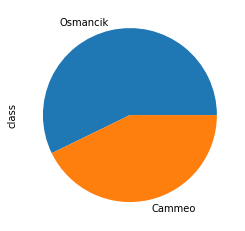

In [20]:
rice["class"].value_counts().plot.pie(colors=[osmancik_color, cammeo_color]);

Rappresentiamo ora la distribuzione dei valori delle singole features al fine di graficare la loro distribuzione rispetto alla loro frequenza.

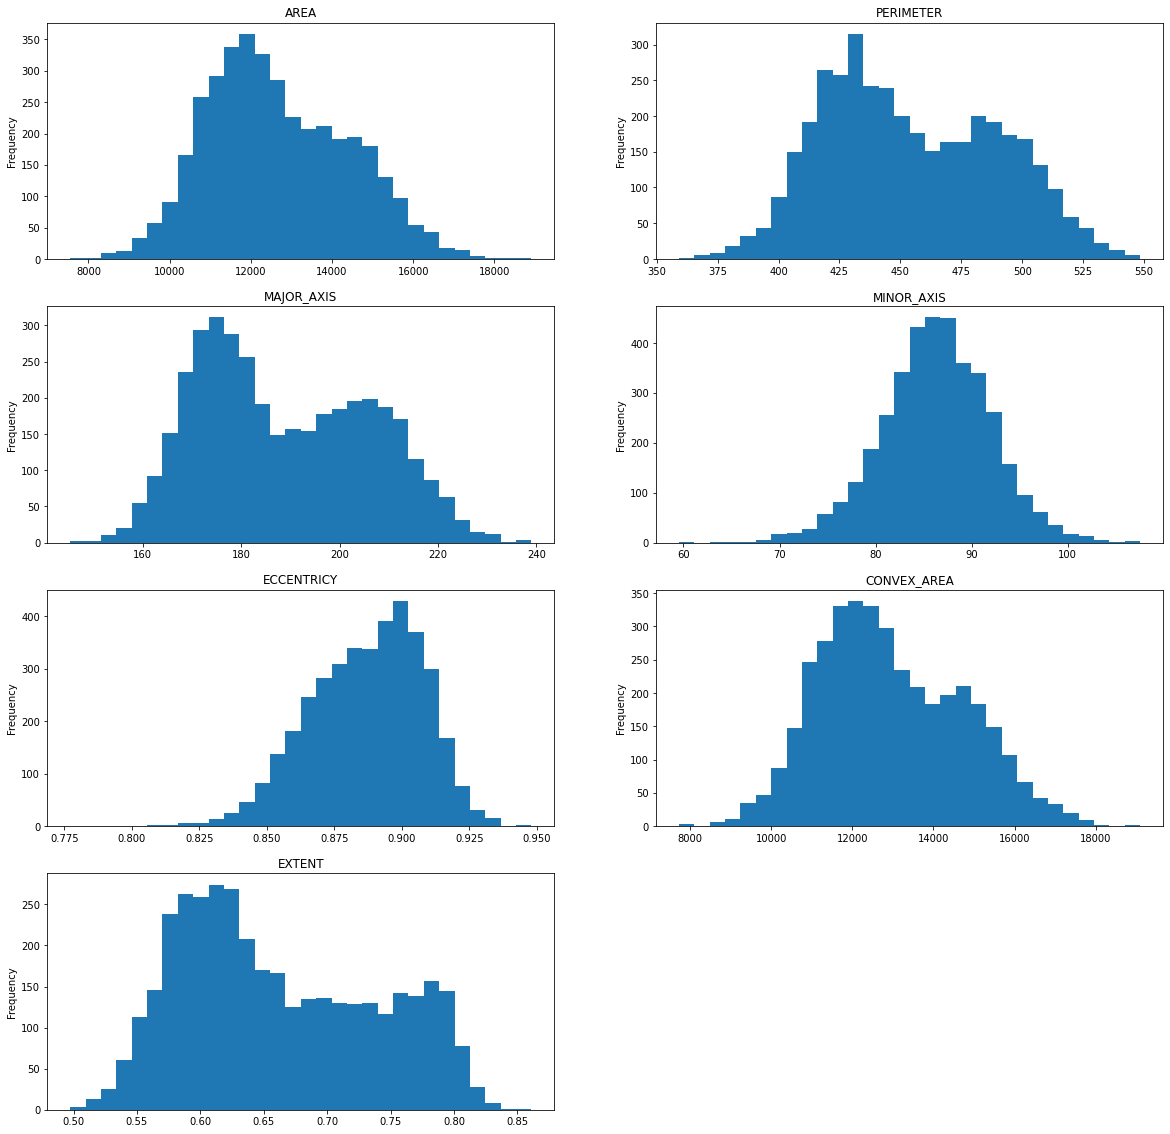

In [21]:
plt.figure(figsize=(20, 20))
for n, col in enumerate(["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent"], start=1):
    rice[col].plot.hist(ax=plt.subplot(4, 2, n),title=col.upper(), bins=30)

- Da questi grafici osserviamo che alcune delle features ("area", "minor_axis", "eccentricy") hanno una distribuzione concentrata tendente a una distrubizione gaussiana, il che potrebbe far pensare che per quelle caratteristiche le due varietà di riso siano simili;
 
 
- Mentre si osserva che le altre feature hanno una distribuzione meno concentrata creando quasi due "campane" o meglio picchi distinti, il che porta a pensare che queste siano le feature che potrebbero caratterizzare di più le due varietà di riso.

Per avere una visione più chiara dell'analisi precedente si ripropongono gli stessi grafici ma con le classi messe in evidenza.
Le due classi sono "impilate", possiamo vedere la distribuzione di entrambe senza perdere informazione.

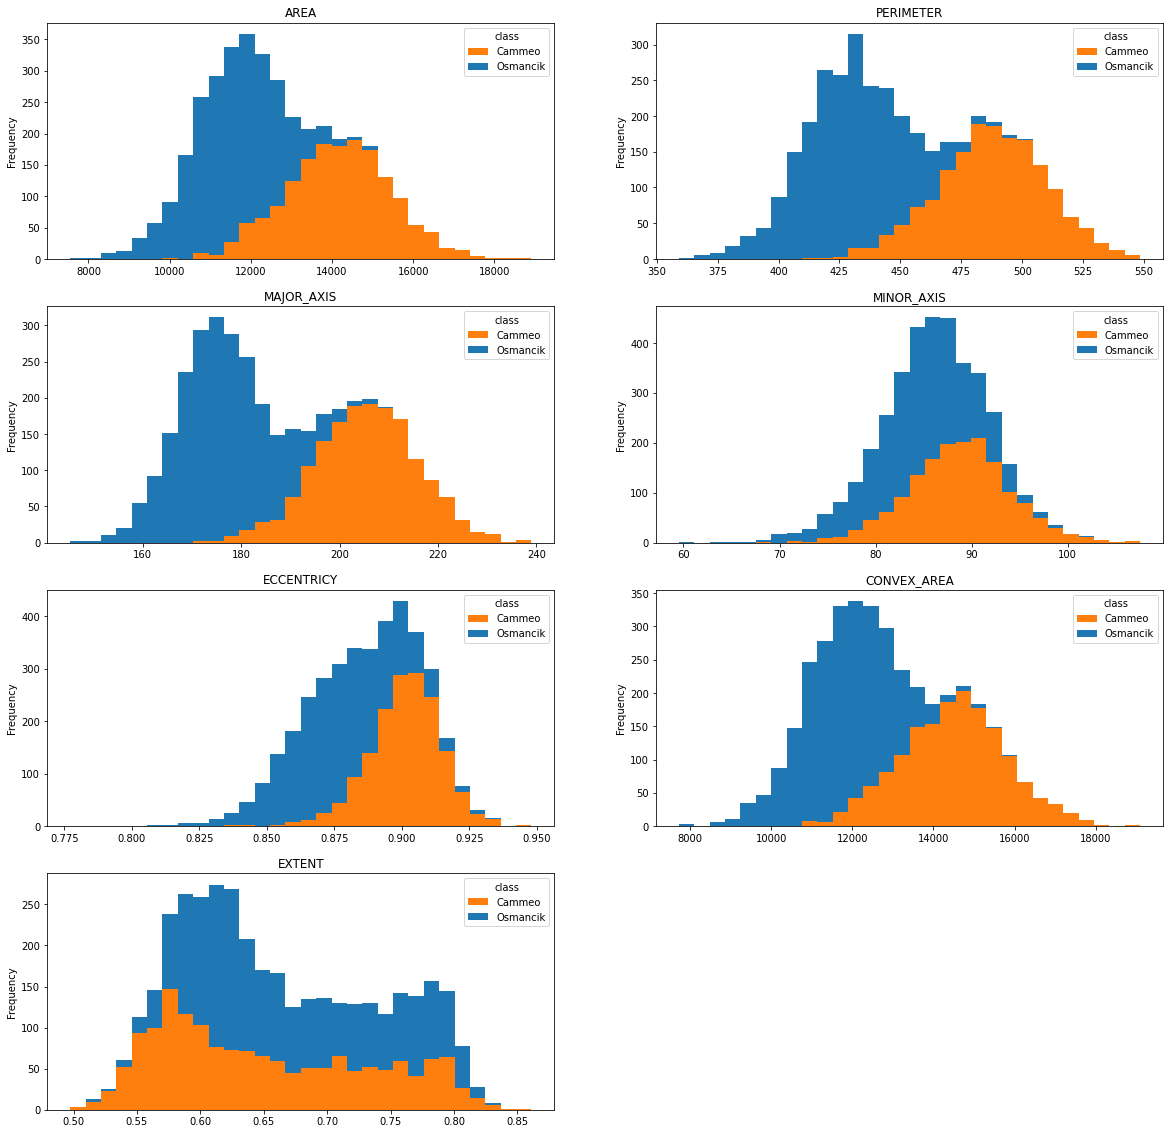

In [22]:
plt.figure(figsize=(20, 20))
for n, col in enumerate(["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent"], start=1):
    rice.pivot(columns="class")[col] \
    .plot.hist(bins=30, stacked=True, ax=plt.subplot(4, 2, n), title=col.upper(), color=[cammeo_color, osmancik_color]);

Come ipotizzato sopra, in questi grafici possiamo notare con più chiarezza che la maggior parte delle feautures che presentano una distribuzione meno concentrata, creando due "picchi", caratterizzano in maniera abbastanza netta le due varietà di riso.

Possiamo notare che le concentrazioni dei valori più alti appartengono alla varietà Cammeo, mentre le concentrazioni di valori più bassi appartengono alla varietà Osmancik.

Diversamente da quanto si era ipotizzato inzialmente, notiamo invece che la distribuzione delle classi per quanto riguarda la feature "extent" è abbastanza omogenea anche se a prima vista si notava la presenza dei due "picchi".


Stessa cosa per quanto riguarda la distribuzione delle features "eccentricy" e "area" che nonostante abbiano una distribuzione tendente a una gaussiana presentano una differenza abbastanza marcata delle due classi, più si va verso i valori alti più la feature caratterizza la varietà di riso Cammeo dalla varietà Osmancik.

Possiamo confermarlo andando a vedere nel dettaglio come sono distribuite le statistiche di base suddivendole per classi.

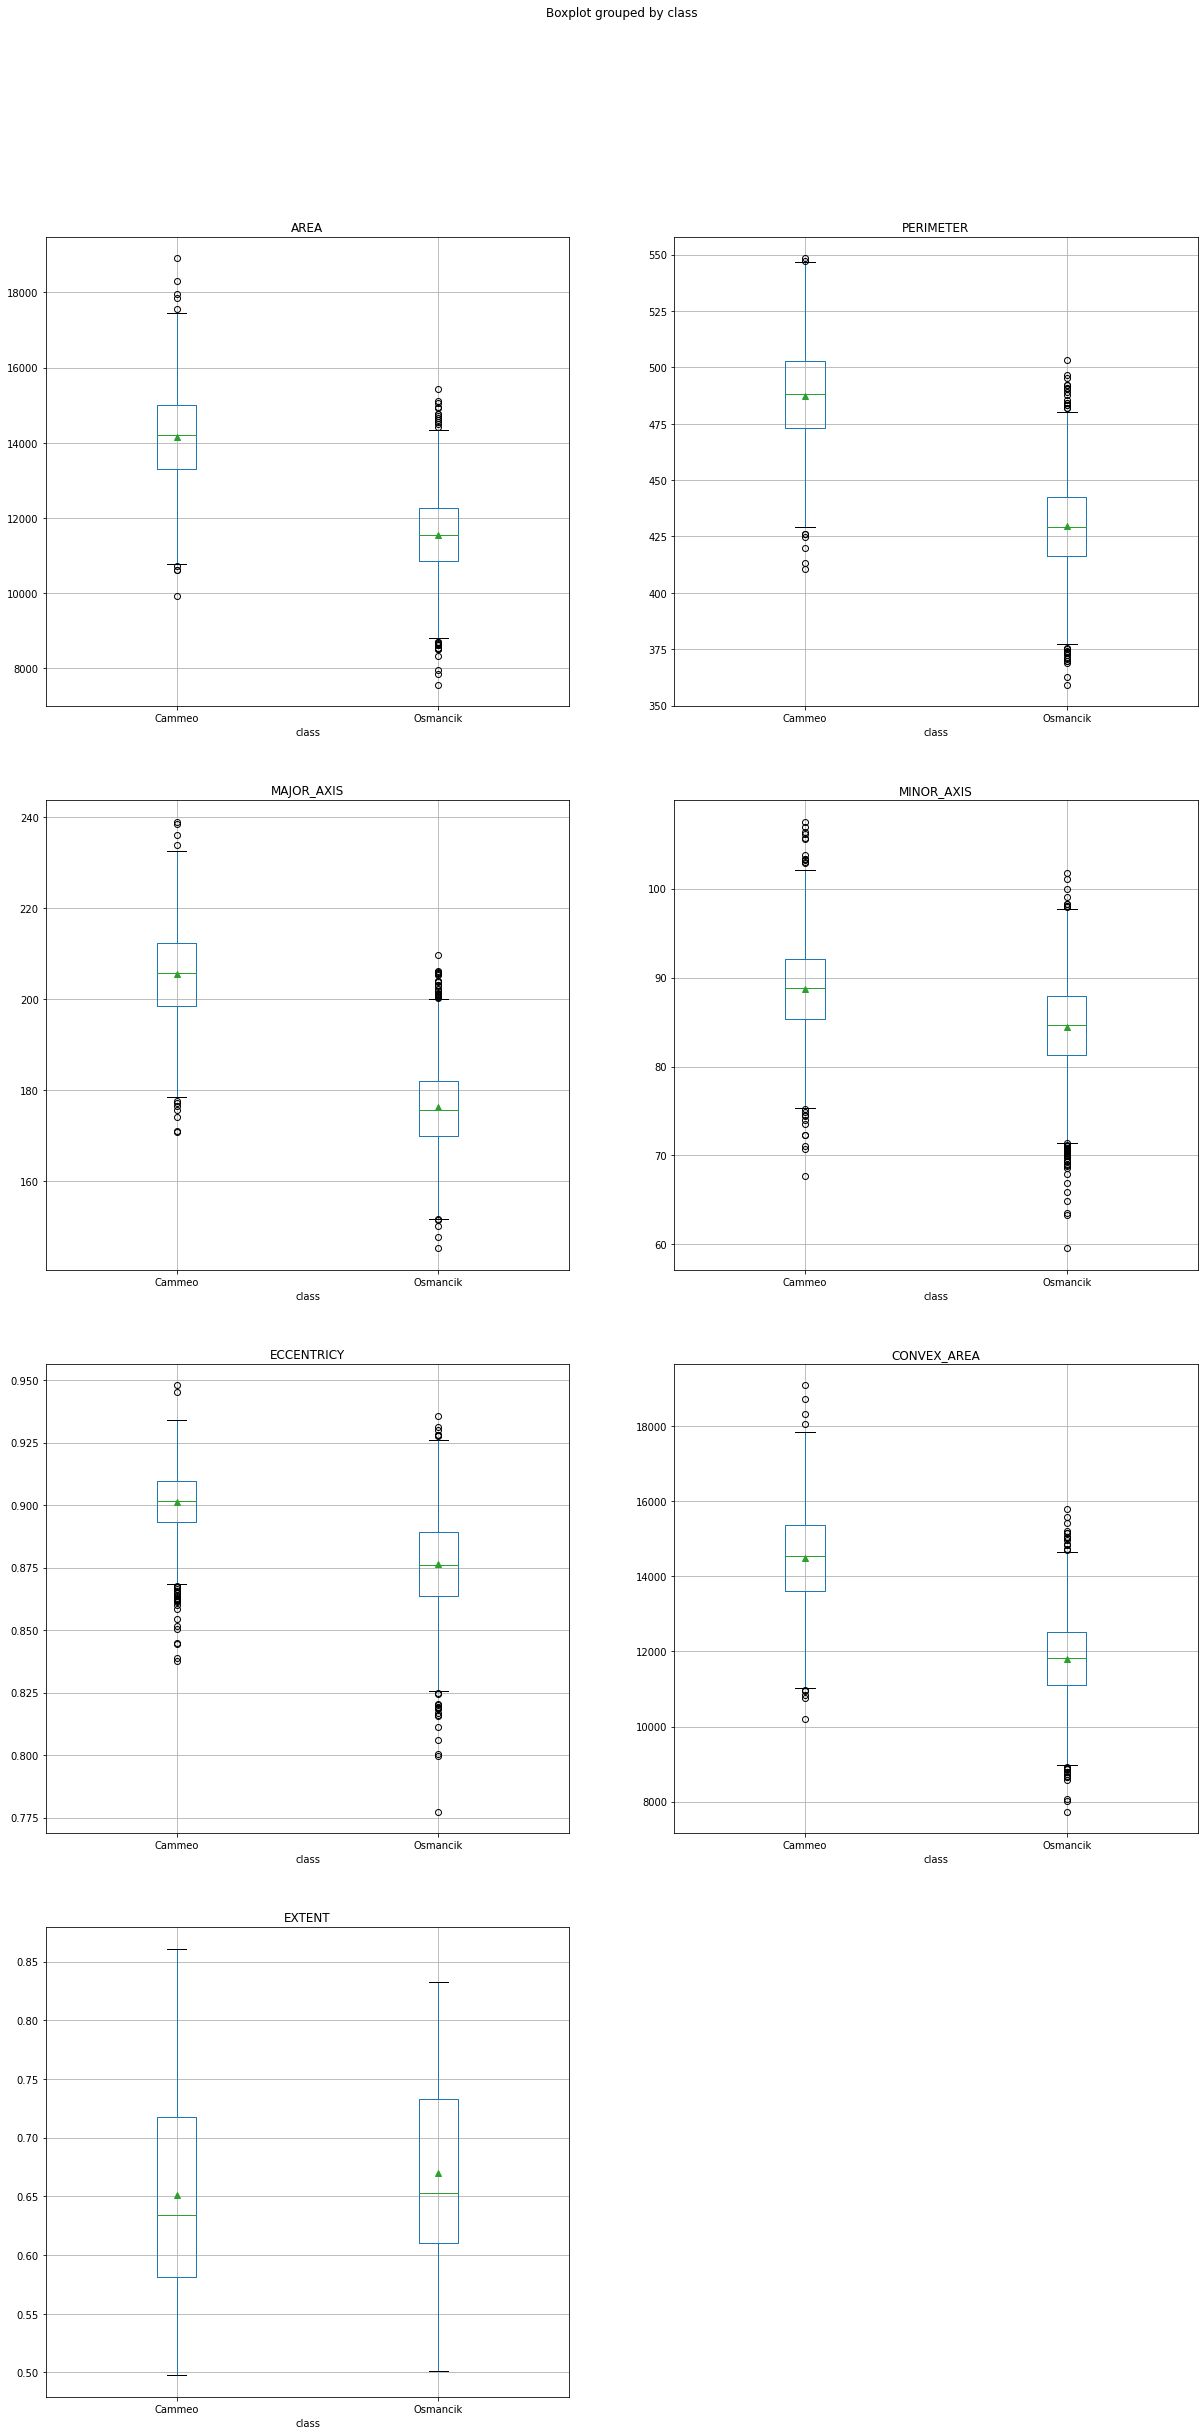

In [23]:
plt.figure(figsize=(20, 40))
for n, col in enumerate(["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent"], start=1):
    rice.boxplot(column=col, by="class", showmeans=True, ax=plt.subplot(4, 2, n))
    plt.title(col.upper())

### Esplorazione relazioni fra feature 

Utilizzando il metodo `corr()` possiamo visualizzare una tabella con le loro correlazioni. Nella diagonale avremo le correlazioni delle features con se stesse, mentre nelle altre celle avremo le correllazioni di features diverse tra loro.

Si crea un nuovo dataframe copiando "rice" ma sostituendo i valori delle classi con 0 e 1 in modo da poter calcolare anche la correlazione tra le classi e le singole features.

In [24]:
rice_binary = rice.replace(to_replace=["Osmancik", 'Cammeo'], value=[0, 1])

In [25]:
correlation = rice_binary.corr()
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent,class
area,1.00,0.97,0.90,0.79,0.35,1.00,-0.06,0.75
perimeter,0.97,1.00,0.97,0.63,0.54,0.97,-0.13,0.81
major_axis,0.90,0.97,1.00,0.45,0.71,0.90,-0.14,0.83
minor_axis,0.79,0.63,0.45,1.00,-0.29,0.79,0.06,0.37
eccentricy,0.35,0.54,0.71,-0.29,1.00,0.35,-0.20,0.59
convex_area,1.00,0.97,0.90,0.79,0.35,1.00,-0.07,0.75
extent,-0.06,-0.13,-0.14,0.06,-0.20,-0.07,1.00,-0.12
class,0.75,0.81,0.83,0.37,0.59,0.75,-0.12,1.00


Dalla tabella sopra riportata notiamo che ci sono diverse correlazioni alte tra coppie di features diverse. Ad esempio c'è una forte correlazione tra l'area e il perimetro del chicco di riso, tra l'area e la lunghezza dell'asse maggiore, mentre non c'è una forte correlazione tra l'area e l'estensione, tra l'estensione e l'eccentricità, ecc.

Nella tabella si possono visualizzare che ci sono delle forti correlazioni tra alcune features e la classe di appartenenza. 

Visualizziamo graficamente la correlazione tra le feautures e le classi.

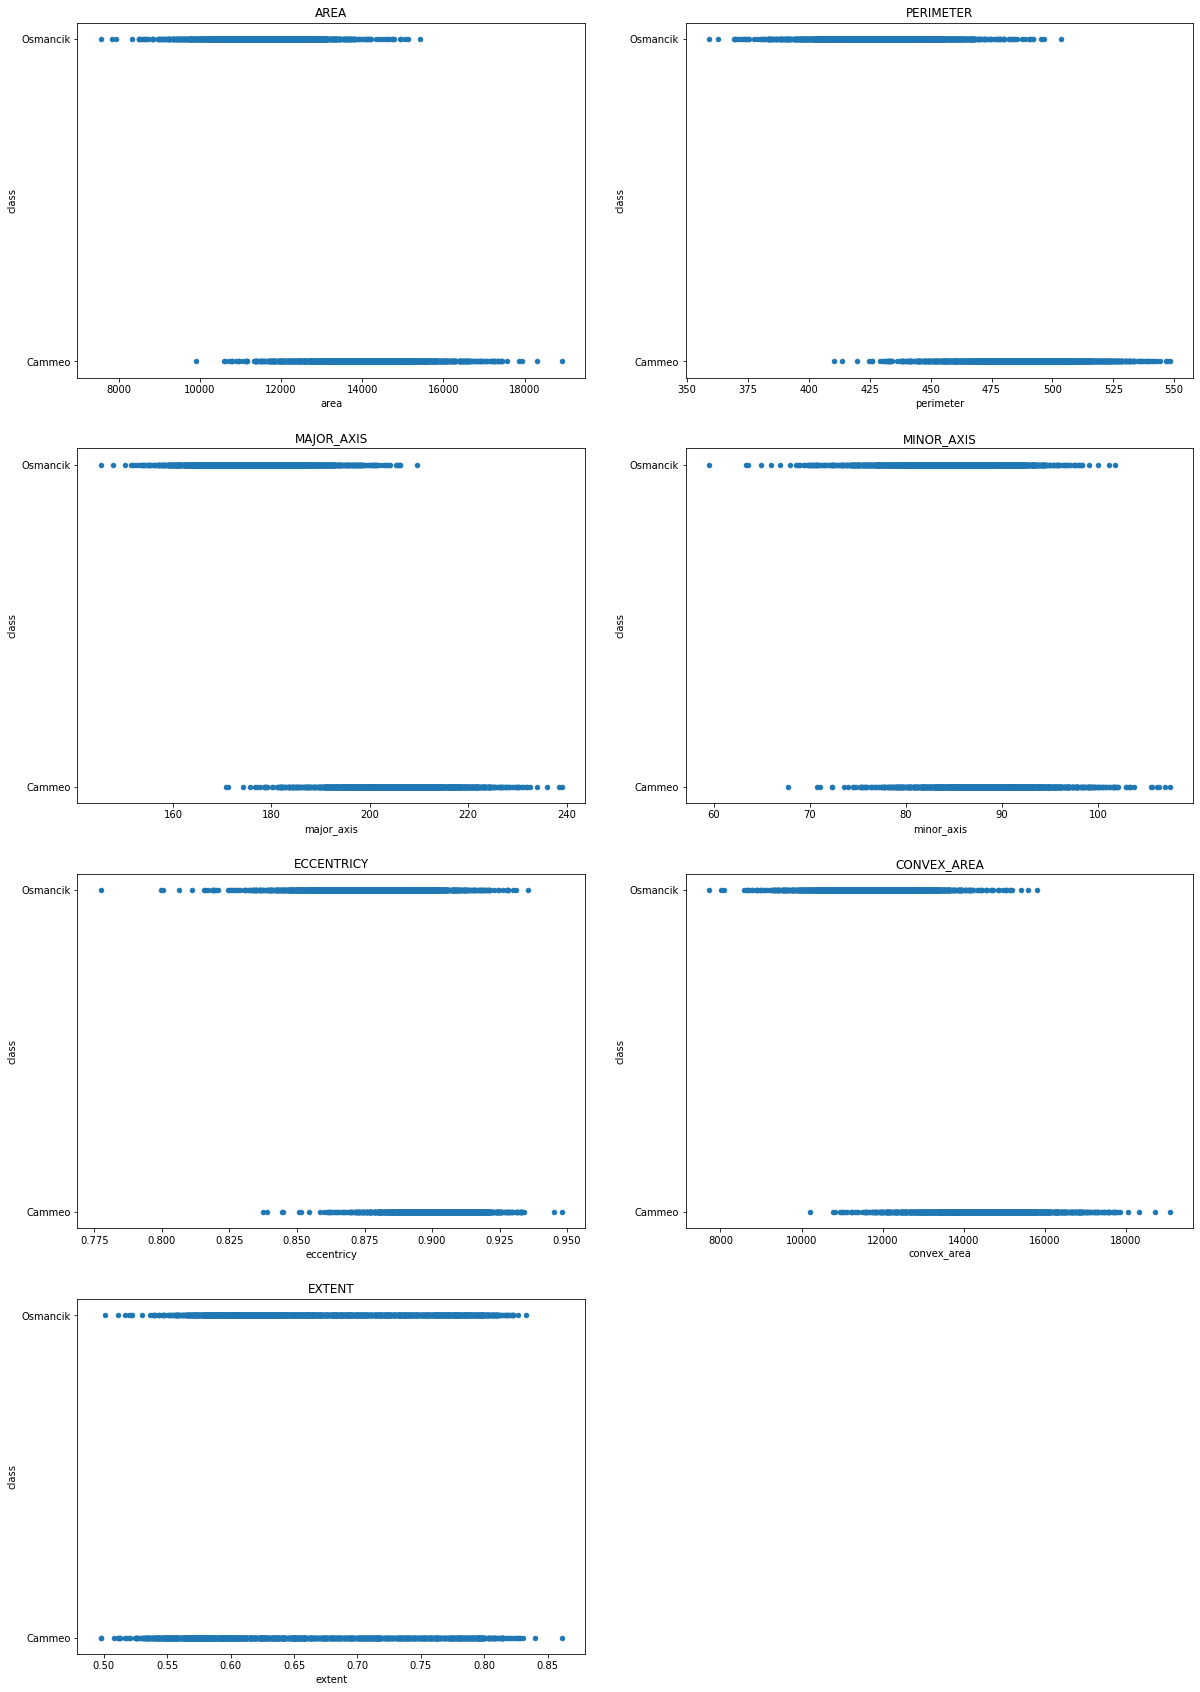

In [26]:
plt.figure(figsize=(20, 30))
for n, col in enumerate(["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent"], start=1):
    rice.plot.scatter(col, "class", ax=plt.subplot(4, 2, n), title=col.upper());

Come osservato anche durante la fase iniziale di analisi dei dati, alcuni grafici mostrano chiaramente che all'aumentare del valore di riferimento si va più verso una classe (Cammeo) e vicersa (Osmancik), mentre per le features "extent", "minor_axis" la correlazione è quasi nulla e probabilmente influirà poco sul tipo di classe di appartenenza.

Visualizziamo ora la distribuzione nello spazio delle due classi prendendo coppie di features. 
Si sceglie di prendere arbitrariamente come riferimento per l'asse delle x il perimetro, mentre per l'asse y le restanti features. Definiamo una funzione che poi sarà utilizzata anche successivamente.

In [27]:
def plot_features_realtionship (X, y=None):
    plt.figure(figsize=(20, 20))
    for n, col in enumerate(["area", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent"], start=1):
        if y is None:
            X.plot.scatter("perimeter", col, c=rice_colors, s=5, ax=plt.subplot(3, 2, n))
        else:
            X.plot.scatter("perimeter", col, c=y.map(rice_color_map), s=5, ax=plt.subplot(3, 2, n))

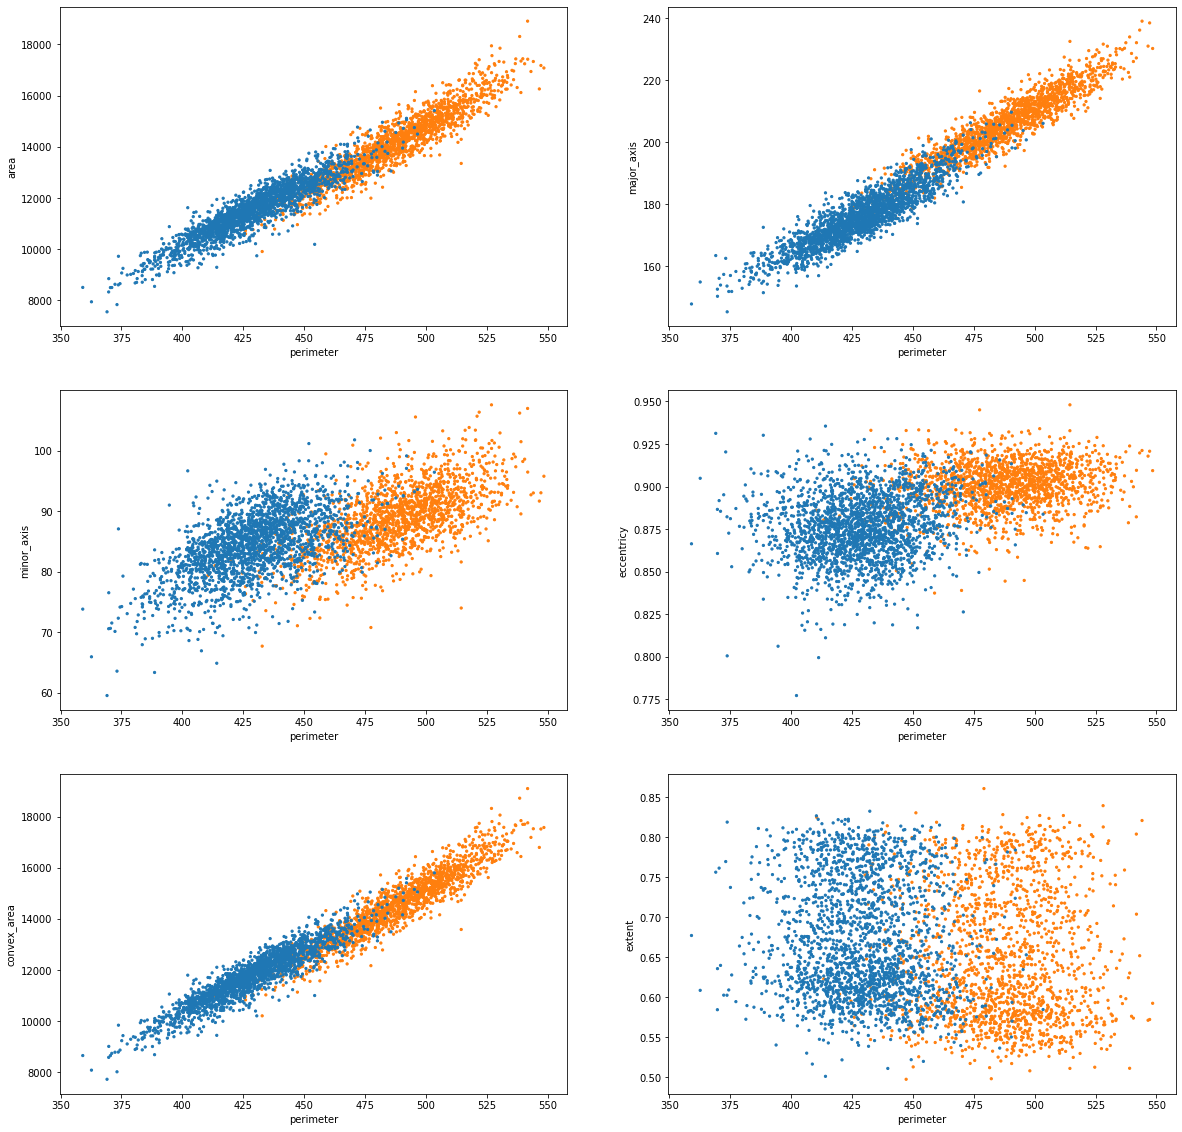

In [28]:
plot_features_realtionship(rice)

Come già abbiamo notato, anche qui si può osservare che tra il perimetro e alcune features esiste una forte correlazione lineare. Quello che si nota maggiormente in questi grafici è l'esistenza di una distinzione abbastanza evidente tra le due classi.

Possiamo già dire che con una semplice classificazione lineare non riusciremmo in alcun caso a distinguere nettamente le due classi, ma potremmo ottenere un buon risultato. 

## Parte 2 - Preprocessing

La parte di preprocessing si occupa di elaborare i dati delle feautures in modo da renderle interpretabili / utilizzabili ai modelli di learning.

Nel nostro caso di studio abbiamo tutte le features numeriche reali, quindi non si ha la necessità di utilizzare la codifica one-hot-encoding, utilizzata per rappresentare in forma vettoriale le variabili categoriche.

Avendo variabili numeriche abbiamo la possibilità di standardizzarle, questa procedura ci permette di mettere sullo stesso piano tutte le nostre features andando a risolvere i problemi di scalabilità dei dati.

Prima di andare a effettuare le trasformazioni delle features, importiamo le librerie necessarie e selezioniamo i dati su cui lavorare:
- la variabile y da predire è la classe: Osmancik o Cammeo;
- le variabili X le restanti features, le caratteristiche morfologiche.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import warnings #Per nascondere i convergeWarning dei filtri
warnings.filterwarnings("ignore")

In [30]:
y = rice["class"]
X = rice.drop(columns="class")

### Hold-Out

Avendo il dataset per intero, dobbiamo ricorrere al metodo `Hold-Out` per suddividere i dati in train set e validation set.

Sul train set andremo ad addestrare i nostri modelli, sul validation set a validarli.
Suddividiamo i dati in training set e in validation set con la funzione `train_test_split`

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,             # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Andiamo a verificare come sono stati suddivisi i dati

In [32]:
X_train.shape, X_val.shape

((2540, 7), (1270, 7))

In [33]:
y_train.shape, y_val.shape

((2540,), (1270,))

Notiamo che sono state riservate 2540 osservazioni per il train e 1270 osservazioni per il validation.



Visualizziamo nuovamente la distribuzione delle classi in base alle loro features ma questa volta riferita solamente ai dati presenti validation set. 

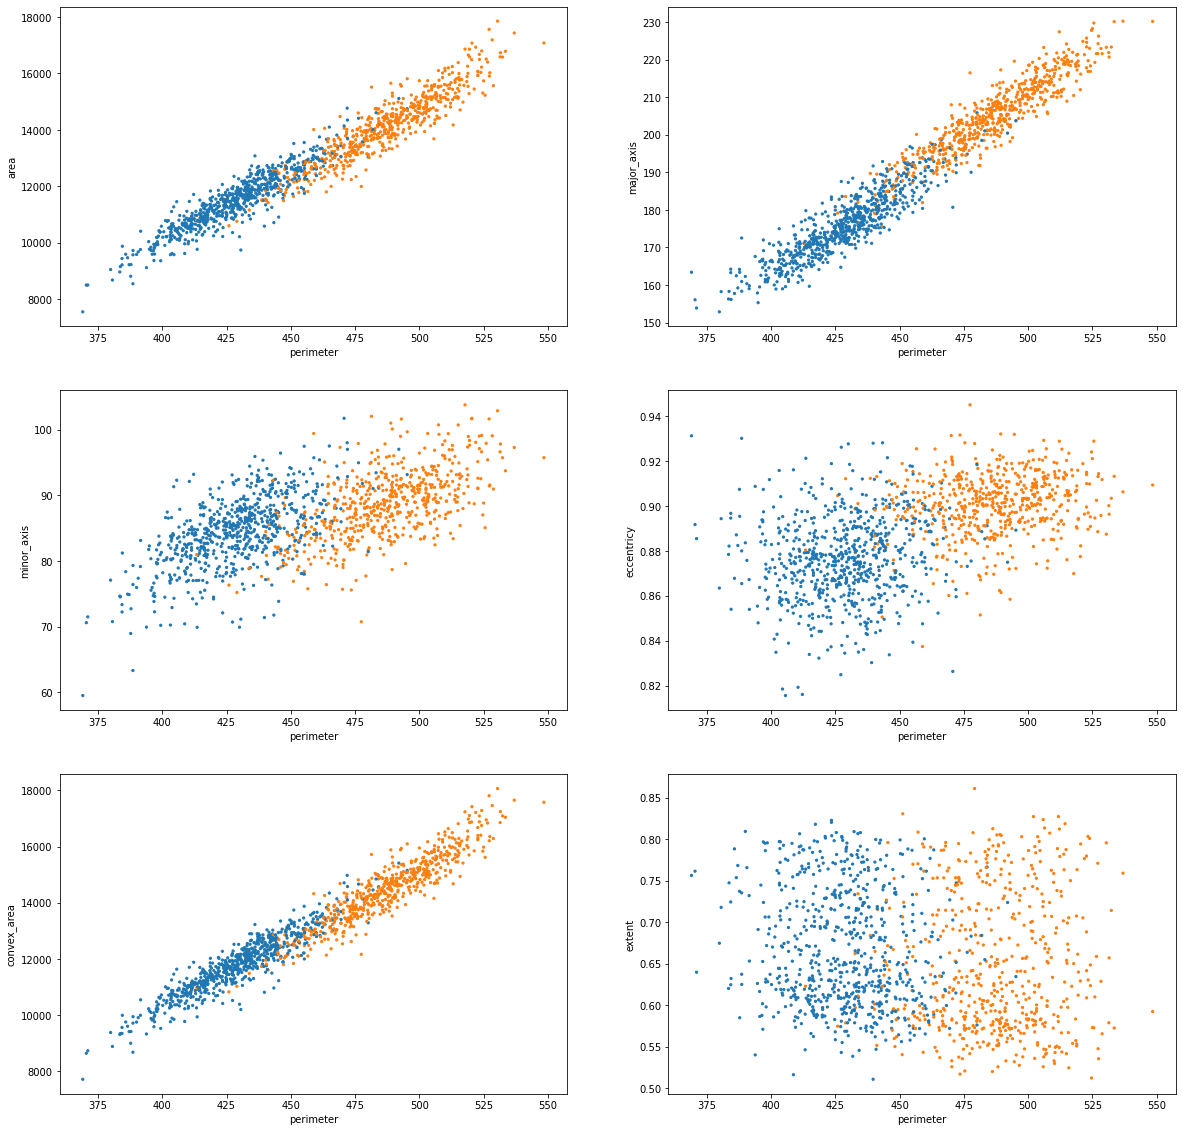

In [34]:
plot_features_realtionship(X_val, y_val)

Notiamo che le distribuzioni sono rimaste simili a prima ma con i grafici meno popolati data la minor presenza di osservazioni.

### Perceptron, Logistic Regression, Multi-layer Perceptron Classifier

Per sondare il terreno, proviamo a classificare le due classi adottando modelli di classificazione lineare in forma semplice.

Il `perceptron` è un algoritmo di apprendimento molto semplice e concettualmente simile alla discesa gradiente
i parametri sono inizializzati casualmente si itera il training set: per ogni istanza mal classificata, i parametri vengono aggiornati proporzionalmente ai valori di x e ad un learning rate preimpostato.

La `Logistic Regression` è un modello di classificazione binaria basato sulla regressione lineare

Il `Multi-layer Perceptron Classifier` è un modello di rete neurale semplice il cui output è un iperpiano determinato dalla combinazione lineare delle variabili in input, ognuna con un peso diverso.

#### Perceptron

- Proviamo un primo approcio generando un modello Perceptron semplice senza la standardizzazione delle variabili. Impostiamo il seed per garantire la riproducibilità degli esperimenti e lo addestriamo sui dati di training.

In [35]:
model_perceptron = Perceptron(random_state=123)
model_perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=123, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Utilizziamo il metodo score per validare l'accuratezza del modello sui dati di validation

In [36]:
model_perceptron.score(X_val, y_val)

0.6763779527559055

Notiamo che con un modello base e senza standardizzazione delle features abbiamo ottenuto uno score del 67%. 
Un modello per essere accettabile dovrebbe avere uno score di almeno il 70/75%, il punteggio da noi ottenuto è basso.

#### Logistic Regression

- Facciamo la stessa cosa per il modello Logistic Regression, anche qui impostiamo il seed.

In [37]:
model_log_reg = LogisticRegression(solver="saga", random_state=123)
model_log_reg.fit(X_train, y_train)
model_log_reg.score(X_val, y_val)

0.7393700787401575

Notiamo che con la Logistic Regression abbiamo ottenuto abbastanza al limite, il 74%

#### MLPClassifier

- Stesso approcio per il modello MLPClassifier

In [38]:
model_mlp = MLPClassifier(random_state=123)
model_mlp.fit(X_train, y_train)
model_mlp.score(X_val, y_val)

0.5519685039370079

In questo caso abbiamo ottenuto un punteggio molto basso.

### StandardScaler

Utilizziamo il filtro `StandardScaler` di sklearn per la standardizzazione dei dati. 
Proviamo a standardizzare le features, ricreiamo i modelli sopra, li riaddestriamo e li valutiamo col metodo score.

In [39]:
scaler = StandardScaler()
Xn_train = scaler.fit_transform(X_train)
Xn_val = scaler.transform(X_val)

#### Perceptron

- Perceptron semplice con dati stardardizzati.

In [40]:
model = Perceptron(random_state=123)
model.fit(Xn_train, y_train)
model.score(Xn_val, y_val)

0.9188976377952756

Notiamo che applicando la standardizzazione delle feature, abbiamo migliorato di molto lo score del modello rispetto a prima.

#### Logistic Regression

- Logistic Regression semplice con dati stardardizzati.

In [41]:
model_prova = LogisticRegression(solver="saga", random_state=123)
model_prova.fit(Xn_train, y_train)
model_prova.score(Xn_val, y_val)

0.9307086614173228

Notiamo che applicando la standardizzazione delle feature abbiamo migliorato di molto lo score del modello

#### MLPClassifier

- MLPClassifier semplice con dati stardardizzati.

In [42]:
model_prova = MLPClassifier(random_state=123)
model_prova.fit(Xn_train, y_train)
model_prova.score(Xn_val, y_val)

0.931496062992126

Notiamo che applicando la standardizzazione delle feature, abbiamo migliorato, anche in questo caso, di molto lo score del modello. Con l'accuratezza del 93% abbiamo ottenuto un modello migliore rispetto a prima.

#### Osservazioni

Abbiamo notato in tutti e tre i modelli che applicando la standardizzazione delle feature abbiamo avuto degli score superiori al 90%.
Abbiamo ottenuto dei modelli migliori rispetto a prima, ma che ancora non separano del tutto le due classi.

Con questi passaggi abbiamo dimostrato che in fase di preprocessing conviene standardizzare le feature.

### Bilanciamento delle Classi

Proviamo a vedere graficamente come si comporta il Perceptron e se è influenzato dal bilanciamento delle classi. Per poterlo fare prendiamo in considerazione solamente le features "perimeter" e "extent".

Vengono definite le funzioni per rappresentare il modello 2D con le features standardizzate.

In [43]:
def separator_2d(model, x1):
    w1 = model.coef_[0, 0]
    w2 = model.coef_[0, 1]
    b = model.intercept_[0]
    return (w1/w2) * x1 - (b/w2)

In [44]:
def plot_separator_on_data(X, y, model=None):
    X = np.array(X)
    colors = pd.Series(y).map(rice_color_map)
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=3)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="red", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)

Si crea il dataframe con le due colonne delle features scelte e la serie delle classi di appartenenza

In [45]:
y = rice["class"]
X2d = rice[["perimeter", "extent"]]

Suddividiamo i dati appena creati in train e validation set

In [46]:
X2d_train, X2d_val, y_train, y_val = train_test_split(
    X2d, y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Prendiamo i dati e li trasformiamo utilizzando il filtro `StandardScaler()`.

In [47]:
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X2d_train)
X2dn_val = scaler.transform(X2d_val)

#### Perceptron

- Dichirariamo un modello Perceptron con il seed impostato per la riprocibilità dei tentativi, senza standardizzazione e lo addestriamo e lo validiamo.

In [48]:
model = Perceptron(random_state=123)
model.fit(X2d_train, y_train)
model.score(X2d_val, y_val)

0.44803149606299214

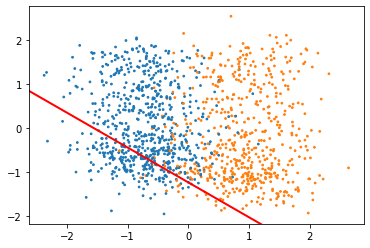

In [49]:
# nota: per poter rappresentare graficamente il modello ottenuto è stato volutamente 
#       utilizzato il set di validation standardizzato.
plot_separator_on_data(X2dn_val, y_val, model) 

Nel grafico sopra, si nota chiaramente che l'iperpiano di separazione generato dal modello Perceptron semplice, non standardizzato e non bilanciato non separa correttamente le due classi.

Addestriamo il modello sui dati standardizzati.

In [50]:
model = Perceptron(random_state=123)
model.fit(X2dn_train, y_train)
model.score(X2dn_val, y_val)

0.9125984251968504

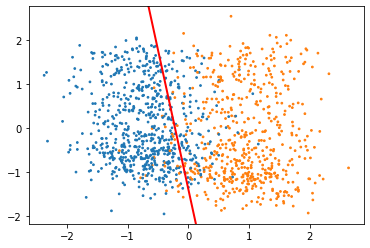

In [51]:
plot_separator_on_data(X2dn_val, y_val, model)

Nel grafico, ora si nota che con l'accuratezza del 91% abbiamo ottenuto un modello migliore ma che ancora non separa correttamente le due classi. Notiamo che alcune istanze blu sono a destra dell'iperpiano di separazione quando la maggioranza di loro si trovano a sinistra, mentre le istanze arancioni sono separate quasi del tutto con qualche istanza che viene classificata erroneamente come di classe blu.

Il modello in esame ha separato meglio la classe arancione da quella blu in quanto ha più peso nella classificazione delle istanze. Nel caso del modello sopra addestrato, l'accuratezza è stata condizionata anche dalla maggior presenza delle istanze arancioni rispetto a quelle blu. 

Proviamo ora a bilanciare il peso delle classi aumentando il numero delle istanze della classe di minoranza attraverso la libreria [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/index.html), utilizzando `RandomOverSampler`. 

RandomOverSampler permette di impostare la strategia di bilanciamento e il seed andando a creare randomicamente altre osservazioni simili a quelle presenti nella classe da bilanciare. Nel nostro caso vogliamo che le classi abbiano lo stesso numero di istanze.

In [52]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

Creiamo l'oggetto RandomOverSampler e impostiamo i parametri

In [53]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

In [54]:
X2d_resampled, y_resampled = ros.fit_resample(X2d, y)

In [55]:
X2d_resampled = pd.DataFrame(X2d_resampled) 

In [56]:
y_resampled = pd.Series(y_resampled)

Verifichiamo il numero delle istanze. Notiamo che ora le due classi hanno lo stesso numero.

In [57]:
y_resampled.value_counts()

Osmancik    2180
Cammeo      2180
dtype: int64

Dividiamo nuovamente in training e validation set.

In [58]:
X2d_resampled_train, X2d_resampled_val, y_resampled_train, y_resampled_val = train_test_split(
    X2d_resampled, y_resampled,  # dati da suddividere
    test_size=1/3,               # proporzione: 2/3 training, 1/3 validation
    random_state=42              # seed per la riproducibilità
)

In [59]:
scaler = StandardScaler()
X2dn_resampled_train = scaler.fit_transform(X2d_resampled_train)
X2dn_resampled_val = scaler.transform(X2d_resampled_val)

In [60]:
model = Perceptron(random_state=123)
model.fit(X2dn_resampled_train, y_resampled_train)
model.score(X2dn_resampled_val, y_resampled_val)

0.9002751031636864

Abbiamo ottenuto un risultato leggermente inferiore, siamo passati dall'91 % al 90%. Vediamolo graficamente.

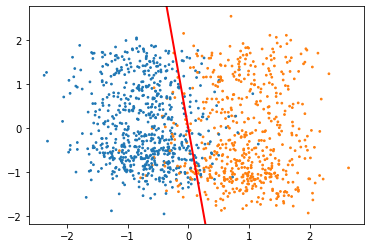

In [61]:
plot_separator_on_data(X2dn_val, y_val, model)

Anche se abbiamo ottenuto uno score leggermente più basso, si nota che l'iperpiano di separazione si è spostato leggermente più destra andando a separare visivamente meglio le due classi. 

Questo perché il modello Perceptron nella sua semplicità implementativa, durante l'addestramento, è più sensibile al bilanciamento delle classi, ciò non dovrebbe accadere con gli altri due modelli di learning che abbiamo considerato.

#### Logistic Regression

- Per correttezza, proviamo ad addestrare il modello Logistic Regression con i training e validation set bilanciati.

In [62]:
# Modello senza bilanciamento
model = LogisticRegression(solver="saga", random_state=123)
model.fit(X2dn_train, y_train)
model.score(X2dn_val, y_val)

0.9196850393700787

In [63]:
# Modello con bilanciamento
model = LogisticRegression(random_state=123)
model.fit(X2dn_resampled_train, y_resampled_train)
model.score(X2dn_resampled_val, y_resampled_val)

0.8961485557083907

#### MLPClassifier

- Idem con il  MLPClassifier, proviamo ad addestrare il modello con i training e validation set bilanciati.

In [64]:
# Modello senza bilanciamento
model = MLPClassifier(random_state=123)
model.fit(X2dn_train, y_train)
model.score(X2dn_val, y_val)

0.9204724409448819

In [65]:
# Modello con bilanciamento
model = MLPClassifier(random_state=123)
model.fit(X2dn_resampled_train, y_resampled_train)
model.score(X2dn_resampled_val, y_resampled_val)

0.8968363136176066

Notiamo che in questo caso abbiamo peggiorato le accuratezze dei modelli, siamo passati dal 92% al 90%.

#### Osservazioni

Abbiamo notato che il bilanciamento delle classi, in questo caso, è tollerato meglio con il Perceptron, mentre con gli altri due modelli si ha una perdita di accuratezza.

Essendo i dati, per bilanciare le due classi, generati causualmente si sceglie di non bilanciare il dataset originale. In fase di modellazione, effetturemo comunque, in aggiunta, una ricerca degli iperparametri migliori con le classi bilanciate solamente al modello Perceptron.

### Pipeline
Per prima cosa, si vuole utilizzare l'oggetto `Pipeline` importato da sklearn. Pipeline ci consentirà di sfruttare l'interfaccia di sklearn incapuslando le trasformazioni (preprocessing) delle variabili e il modello da applicare. Finora abbiamo visto che è necessaria la standardizzazione.

### Regolarizzazione l1 (Lasso)

Proviamo ora ad applicare al modello sopra sia la standardizzazione che la regolarizzazione `l1`. Con la regolarizzazione "l1" saremo in grado di vedere se esistono feature poco rilevanti per l'addrestamento del modello.

#### Perceptron


- In questo caso riprendiamo il modello Perceptron, addrestriamo due modelli, entrambi con standardizzazione dei dati, ma uno senza regolarizzazione e l'altro con la regolarizzazione "l1".

In [66]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Perceptron(random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9188976377952756

Vediamo i pesi delle features senza la regolarizzazione "l1"

In [67]:
pd.DataFrame(model.named_steps["linreg"].coef_, index=["weight"], columns=X_train.columns)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent
weight,8.308346,-1.632718,-2.791846,1.475367,-0.145859,-16.951401,-0.928883


Con regolarizzazone "l1".

In [68]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Perceptron(random_state=123, penalty="l1", alpha=0.01))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.926771653543307

Vediamo i pesi delle features con la regolarizzazione "l1"

In [69]:
pd.DataFrame(model.named_steps["linreg"].coef_, index=["weight"], columns=X_train.columns)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent
weight,0.0,-0.626875,-2.303003,0.0,0.0,0.0,0.0


Osservando i parametri appresi dai due modelli osserviamo che effettuando la regolarizzazione "l1" ci sono alcune features che hanno un peso pari a zero.

Osservando invece gli score notiamo che il modello con regolarizzazione ottiene un punteggio inferiore.

#### Logistic Regression


- Stesso procedimento con la Logistic Regression

In [70]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", LogisticRegression(solver="saga", random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9307086614173228

Vediamo i pesi delle features senza la regolarizzazione "l1"

In [71]:
pd.DataFrame(model.named_steps["linreg"].coef_, index=["weight"], columns=X_train.columns)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent
weight,-0.136174,-0.981657,-0.849949,0.361758,-1.27975,-2.098372,-0.106927


Con regolarizzazone "l1".

In [72]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", LogisticRegression(solver="saga", random_state=123, penalty="l1", C=0.01))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9291338582677166

Vediamo i pesi delle features con la regolarizzazione "l1"

In [73]:
pd.DataFrame(model.named_steps["linreg"].coef_, index=["weight"], columns=X_train.columns)

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent
weight,0.0,0.0,-2.719398,0.0,0.0,0.0,0.0


Osservando i parametri appresi dai due modelli osserviamo che effettuando la regolarizzazione "l1" ci sono alcune features che hanno un peso pari a zero.

Osservando invece gli score notiamo che il modello con regolarizzazione ottiene un punteggio leggermente inferiore, ma è stato addestrato utilizzando meno features.

#### MLPClassifier


- Per il MLPClassifier non è implementara la regolarizzazione "l1", è implementata di default la regolarizzazione "l2" attraverso il parametro alpha impostato a 0.0001. Anche se concettualmente sono diverse, vogliamo osservare ugualmente i pesi generati dal modello.

In [74]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", MLPClassifier(random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.931496062992126

Vediamo i pesi delle features con la regolarizzazione "l2".

In [75]:
pd.set_option('display.max_columns', None) # per visualizzare tutte le colonne
pd.DataFrame(model.named_steps["linreg"].coefs_[0], index=X_train.columns, columns=["Node_" + str(x) for x in range(0,100)])

,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9,Node_10,Node_11,Node_12,Node_13,Node_14,Node_15,Node_16,Node_17,Node_18,Node_19,Node_20,Node_21,Node_22,Node_23,Node_24,Node_25,Node_26,Node_27,Node_28,Node_29,Node_30,Node_31,Node_32,Node_33,Node_34,Node_35,Node_36,Node_37,Node_38,Node_39,Node_40,Node_41,Node_42,Node_43,Node_44,Node_45,Node_46,Node_47,Node_48,Node_49,Node_50,Node_51,Node_52,Node_53,Node_54,Node_55,Node_56,Node_57,Node_58,Node_59,Node_60,Node_61,Node_62,Node_63,Node_64,Node_65,Node_66,Node_67,Node_68,Node_69,Node_70,Node_71,Node_72,Node_73,Node_74,Node_75,Node_76,Node_77,Node_78,Node_79,Node_80,Node_81,Node_82,Node_83,Node_84,Node_85,Node_86,Node_87,Node_88,Node_89,Node_90,Node_91,Node_92,Node_93,Node_94,Node_95,Node_96,Node_97,Node_98,Node_99
area,0.074635,-0.188826,-0.135493,-0.011772,0.072730,-0.035183,0.226563,0.080003,0.125399,-0.072865,-0.162196,0.274387,-0.006576,-0.259754,0.016321,0.296888,-0.111492,-0.082007,-0.092285,-0.044934,0.012219,0.191911,0.070963,0.010055,0.097523,-0.055061,-0.161784,-0.110297,-0.063305,-0.001180,-0.159304,-0.091775,-0.109359,0.158712,-0.059554,-0.099160,-0.001075,0.325776,0.218981,-0.027581,0.036654,-0.274169,-0.153646,-0.117018,0.161556,-0.153249,-0.025795,0.311646,-0.002683,0.214722,-0.172144,0.118361,0.012068,0.030220,-0.087927,-0.126159,-0.144523,0.055657,0.128787,0.044595,0.033999,0.020210,0.017242,0.096815,0.145557,-0.288861,0.089757,-0.095814,-0.169485,-0.035996,-0.157662,0.132889,-0.038595,0.218454,-0.209808,0.100367,-0.056664,-0.084785,-0.149093,0.058582,-0.114249,0.021989,0.028811,0.211495,0.089729,0.102970,-0.047729,-0.230606,-0.009783,-0.050606,0.103239,0.179177,-0.083820,0.238734,0.137383,0.100474,-0.226210,-0.078282,-0.181584,-0.071362
perimeter,0.037504,0.034290,-0.117179,-0.276144,-0.161366,0.167127,0.237228,-0.020361,0.234651,-0.177575,-0.169645,0.011336,-0.052001,0.070771,-0.004987,0.100618,0.079582,0.073520,-0.305793,0.338249,0.212695,-0.131734,-0.154297,-0.038962,0.212631,0.203651,-0.100612,0.013323,0.321375,-0.097541,0.135911,-0.184862,-0.128604,0.272368,0.212263,-0.160342,0.057897,-0.019474,-0.046902,0.217039,-0.298878,-0.205635,0.150104,-0.062688,-0.079638,0.068713,0.152290,-0.124629,0.135686,0.228595,-0.130704,0.112323,-0.306840,-0.039338,0.003091,-0.263997,-0.105155,0.185871,0.014702,-0.047474,-0.144507,0.050670,-0.018393,-0.248983,0.113480,0.061473,-0.207344,0.268019,0.160969,-0.037287,0.176867,-0.444715,0.079141,0.216905,0.277359,-0.117553,-0.352221,-0.099472,-0.037881,-0.090136,-0.021380,-0.297639,-0.128041,0.283163,-0.014529,0.089480,-0.292758,0.092833,0.264173,-0.043419,-0.243939,0.161041,0.011811,0.151408,-0.132211,0.132809,-0.151595,0.046299,0.010330,-0.144037
major_axis,0.056571,-0.242416,0.116932,0.154921,0.081980,-0.112009,-0.125629,0.044881,0.155827,-0.303431,0.075959,0.110673,0.043729,0.034730,0.016166,0.072997,-0.103690,-0.004269,0.042799,-0.022143,-0.006893,0.232359,-0.170480,0.127371,0.214896,-0.245138,-0.035420,-0.013327,0.100211,-0.308646,-0.089348,-0.273207,-0.279947,0.281935,0.148704,-0.179442,-0.022172,0.360723,0.009352,0.235123,-0.299314,-0.054707,0.175363,-0.134332,-0.230677,-0.066685,0.240163,0.006120,0.185604,0.229260,-0.116696,-0.082763,-0.016372,0.023439,-0.232337,0.173311,-0.117843,0.190954,-0.297044,-0.124094,-0.069404,-0.277697,0.181492,-0.172316,0.019426,-0.206860,-0.248705,-0.052314,-0.162009,-0.017287,-0.051493,-0.209925,-0.376249,0.027924,0.100222,-0.114778,-0.055532,-0.042543,0.061237,-0.281009,0.126964,-0.306172,-0.160303,0.302247,-0.351632,0.039048,0.196141,0.243027,0.191290,0.151131,-0.115600,0.260114,-0.009930,0.293641,-0.078133,0.306306,0.170416,0.098815,-0.178368,0.092233
minor_axis,-0.256016,0.050052,-0.205462,-0.239205,-0.203951,0.480292,-0.090668,0.044940,0.187302,-0.085350,-0.063392,0.229973,-0.047405,-0.068050,0.088440,0.374582,0.017035,0.229188,0.021927,-0.131777,-0.309778,0.045808,0.123908,-0.186646,-0.192027,0.024527,-0.103680,0.175789,-0.235747,0.362051,0.110791,0.264921,0.267714,0.2

#### Osservazioni

Abbiamo notato che la regolarizzazione "l1" in alcuni casi tende a peggiorare leggermente lo score, in altri lo migliora considerando che viene addestrato un modello sulla base di meno features.

In fase di modellazione si terrà conto di testare la ricerca degli iperparametri migliori anche attraverso la regolarizzazione "l1".

### PolynomialFeatures

Ora proviamo a introdurre il filtro `PolynomialFeatures`. Questo filtro permette di generare una nuova matrice di features costituita da tutte le combinazioni polinomiali delle stesse con grado inferiore o uguale al grado specificato.

#### Perpeptron

Con filtro PolynomialFeatures e grado 2.

In [76]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", Perceptron(random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9110236220472441

#### Logistic Regression

Con filtro PolynomialFeatures e grado 2.

In [77]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LogisticRegression(solver="saga", random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9307086614173228

#### MLPClassifier

Con filtro PolynomialFeatures e grado 2.

In [78]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", MLPClassifier(random_state=123))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9244094488188976

#### Osservazioni

Notiamo che, rispetto ai modelli senza il filtro PolynomialFeatures, non abbiamo guadagnato in termini di score, ma siamo riusciti a mantenere la stessa accuratezza.

In fase di modellazione si terrà conto di testare la ricerca degli iperparametri migliori anche attraverso l'uso PolynomialFeatures.

## Parte 3 - Modellazione 

Importiamo le librerie per la modellazione.

In [79]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import  f1_score

Procederemo creando diversi modelli di classificazione tenendo conto quanto osservato in fase di preprocessing, ovvero lavorando con le features standardizzate. 

Per poter garantire la riproducibilità dei risultati e confrontare sullo stesso piano i modelli che genereremo, fissiamo i seed arbitrariamente.

### Grid Search e Strified K-fold Cross Validation, Nested Cross-Validation

Tramite **Grid Search** e **Strified K-fold cross validation** verranno generati modelli differenti per individuare gli iperparametri migliori. Durante la fase di studio sono state effettuate e testate diverse combinazioni di iperparametri. Per ridurre i tempi di addestramento verranno riportate solamente quelle combinazioni che hanno generato i `mean_test_score` migliori.

Dovendo addestrare un modello a riconoscere delle classi, è opportuno che le proporzioni di ciascuna classe nei fold siano il più possibile equamente distribuite. Si decide di utilizzare `StratifiedKFold` (variante di `KFold`) che garantisce uguale distribuzione delle classi tra un fold e l'altro.

Creiamo due oggetti Strified K-fold, uno per la cross fold interna e uno per quella esterna.

In [80]:
outer_skf_cv = StratifiedKFold(3, shuffle=True, random_state=888) #Esterna
inner_skf_cv = StratifiedKFold(5, shuffle=True, random_state=888) #Interna

Definiamo una funzione per utilizzare la nested cross-validation per generare k fold "esterni" su tutti i dati disponibili e che per ciascuno si esegua il tuning degli iperparametri con una cross validation "interna" usando le parti di training dei fold esterni.

In [81]:
def nested_cv(model, grid, X=X, y=y):
    results = []
    grid_searchs = []
    for train_indices, val_indices in outer_skf_cv.split(X, y):
        gs = GridSearchCV(model, grid, cv=inner_skf_cv)
        gs.fit(X.iloc[train_indices], y.iloc[train_indices])
        score = gs.score(X.iloc[val_indices], y.iloc[val_indices])
        results.append(score)
        grid_searchs.append(gs)
    return results, grid_searchs

### Perceptron

Viene riproposto nuovamente il Perceptron, questa volta cercando gli iperparametri migliori attraverso la nested stratified cross-fold validation e la grid search. 

Creiamo il modello e la grid.

In [82]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", None),
    ("lr", Perceptron(random_state=123))
])

In [83]:
perceptron_grid = [
    {
        "poly" : [None],
        "lr__penalty" : ["none"]
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "lr__penalty" : ["none"]
    },
    {
        "poly" : [None],
        "lr__penalty": ["l2", "l1", "elasticnet"],
        "lr__alpha": np.logspace(-4, 3, 8)
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "lr__penalty": ["l2", "l1", "elasticnet"],
        "lr__alpha": np.logspace(-4, 3, 8),
    }
]

In [84]:
perceptron_score, perceptron_gs = nested_cv(perceptron_model, perceptron_grid)

Visualizziamo la configurazione (gli iperparametri migliori) del modello che ha ottenuto lo score migliore.


In [85]:
perceptron_best_gs = perceptron_gs[np.argmax(perceptron_score)]
perceptron_best_param = perceptron_best_gs.best_params_
perceptron_best_param

{'lr__alpha': 0.01, 'lr__penalty': 'l1', 'poly': None}

Si riporta il ranking score del modello che ha ottenuto il punteggio migliore.

In [86]:
pd.DataFrame(perceptron_best_gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_poly,param_poly__degree,param_lr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.006411,0.000402,0.002046,0.000056,l1,None,NaN,0.01,"{'lr__alpha': 0.01, 'lr__penalty': 'l1', 'poly...",0.921260,0.891732,0.907480,0.942913,0.937008,0.920079,0.018824,1
1,0.012657,0.001179,0.003850,0.000124,none,"PolynomialFeatures(degree=2, include_bias=Fals...",2,NaN,"{'lr__penalty': 'none', 'poly': PolynomialFeat...",0.911417,0.893701,0.923228,0.925197,0.921260,0.914961,0.011639,2
3,0.009757,0.000615,0.003431,0.000218,l2,None,NaN,0.0001,"{'lr__alpha': 0.0001, 'lr__penalty': 'l2', 'po...",0.903543,0.874016,0.915354,0.931102,0.940945,0.912992,0.023338,3
5,0.006621,0.000629,0.002075,0.000042,elasticnet,None,NaN,0.0001,"{'lr__alpha': 0.0001, 'lr__penalty': 'elasticn...",0.903543,0.874016,0.915354,0.931102,0.940945,0.912992,0.023338,3
35,0.018583,0.001935,0.003805,0.000144,l1,"PolynomialFeatures(degree=2, include_bias=Fals...",2,0.001,"{'lr__alpha': 0.001, 'lr__penalty': 'l1', 'pol...",0.907480,0.897638,0.901575,0.937008,0.893701,0.907480,0.015450,5


#### Accuratezza del modello Perceptron
Si riportano gli score calcolati dalla funzione nested_cv

In [87]:
perceptron_score

[0.9173228346456693, 0.9133858267716536, 0.8700787401574803]

Notiamo che con il modello che ha ottenuto lo score migliore ha una percentuale di accuratezza del 92%. La media di tutti e tre i risultati è pari al 90% 

In [88]:
np.mean(perceptron_score)

0.9002624671916011

Analizziamo il modello che ha ottenuto lo score migliore con le altre metriche di accuratezza.


Estraiamo le predizioni e visualizziamo la matrice di confusione.

In [89]:
perceptron_preds = perceptron_best_gs.predict(X_val)
perceptron_conf_matrix = confusion_matrix(y_val, perceptron_preds)

In [90]:
perceptron_cm_df = pd.DataFrame(perceptron_conf_matrix, columns = ["predicted_"+ x for x in perceptron_best_gs.classes_],
             index = ["real_"+x for x in perceptron_best_gs.classes_])
perceptron_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,537,32
real_Osmancik,58,643


Notiamo che non tutte le istanze della classe Cammeo sono state idendificate correttamente, e quindi qualche chicco di riso della varietà Cammeo è stato erroneamente classificato come facente parte della classe Osmancik. Stessa cosa il contrario, alcune istanze della classe Osmancik sono state classificate erroneamente come facenti parte della classe Cammeo.

La `Precision` indica la percentuale di istanze classificate correttamente come facenti parte di una classe e che sono realmente tali.

In [91]:
perceptron_precision = pd.DataFrame(precision_score(y_val, perceptron_preds, average = None), 
             columns=["Precision_score"], index=perceptron_best_gs.classes_)
perceptron_precision

,Precision_score
Cammeo,0.902521
Osmancik,0.952593


Possiamo vedere che la classe Cammeo è quella che ne ha risentito di più 90%, mentre la classe Osmancik ha ottenuto una precision alta, il 95%.

La `Recall` misura la sensibilità del modello, ci dà l'indicazione di quante istanze reali di una classe sono state rilevate essere tali dal modello

In [92]:
perceptron_recall = pd.DataFrame(recall_score(y_val, perceptron_preds, average = None),
                                 columns=["Recall_score"], index=perceptron_best_gs.classes_)
perceptron_recall

,Recall_score
Cammeo,0.943761
Osmancik,0.917261


Notiamo in questo caso che entrambe la classe Cammeo ha ottenuto una recall del 94%, mentre la classe Osmancik del 92%.

Ora misuriamo l'`F1_Score` che  è la misura di accuratezza che combina insieme la precision e la recall, ovvero la media armonica tra precision e recall, se la differenza tra le due misure è molto forte la media armonica sarà più vicino a quella bassa.

In [93]:
perceptron_f1_measure = pd.DataFrame(f1_score(y_val, perceptron_preds, average = None),
                                     columns=["F1_Measure_score"], index=perceptron_best_gs.classes_)
perceptron_f1_measure

,F1_Measure_score
Cammeo,0.922680
Osmancik,0.934593


Notiamo che abbiamo ottenuto con il Perceptron una buona accuratezza. La media tra le due F1_measure si aggira intorno al 93%

In [94]:
perceptron_f1_mean_measure = f1_score(y_val, perceptron_preds, average = "macro")
perceptron_f1_mean_measure

0.928636717813474

### Perceptron pesato

Per verificare meglio quanto e se influisce il bilanciamento delle classi nel Perceptron, viene riproposto nuovamente il modello e la grid precedenti.

Prendiamo i dataset X e y per effettuare il bilanciamento delle classi.

In [95]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

In [96]:
X_resampled, y_resampled = ros.fit_resample(X, y)

In [97]:
X_resampled = pd.DataFrame(X_resampled)

In [98]:
y_resampled = pd.Series(y_resampled)

Verifichiamo il numero delle istanze. Notiamo che ora le due classi hanno lo stesso numero.

In [99]:
y_resampled.value_counts()

Osmancik    2180
Cammeo      2180
dtype: int64

Creiamo il modello e la grid. La grid la copiamo dal modello Perceptron non pesato.

In [100]:
balanced_perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", None),
    ("lr", Perceptron(random_state=123))
])

In [101]:
balanced_perceptron_grid = perceptron_grid

In [102]:
balanced_perceptron_score, balanced_perceptron_gs = nested_cv(balanced_perceptron_model, balanced_perceptron_grid, X_resampled, y_resampled)

Visualizziamo la configurazione (gli iperparametri migliori) del modello che ha ottenuto lo score migliore.

In [103]:
bal_perceptron_best_gs = balanced_perceptron_gs[np.argmax(balanced_perceptron_score)]
bal_perceptron_best_param = bal_perceptron_best_gs.best_params_
bal_perceptron_best_param

{'lr__alpha': 0.1, 'lr__penalty': 'l1', 'poly': None}

Si riporta il ranking score del modello che ha ottenuto il punteggio migliore.

In [104]:
pd.DataFrame(bal_perceptron_best_gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_poly,param_poly__degree,param_lr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
47,0.016653,0.001116,0.003704,0.000063,l1,"PolynomialFeatures(degree=2, include_bias=Fals...",2,0.1,"{'lr__alpha': 0.1, 'lr__penalty': 'l1', 'poly'...",0.927835,0.924399,0.912220,0.936317,0.908778,0.921910,0.010151,1
13,0.006114,0.000258,0.001873,0.000046,l1,None,NaN,0.1,"{'lr__alpha': 0.1, 'lr__penalty': 'l1', 'poly'...",0.927835,0.924399,0.912220,0.936317,0.908778,0.921910,0.010151,1
0,0.008816,0.000225,0.002987,0.000048,none,None,NaN,NaN,"{'lr__penalty': 'none', 'poly': None}",0.934708,0.860825,0.898451,0.920826,0.903614,0.903685,0.024983,3
7,0.006500,0.000153,0.001834,0.000043,l1,None,NaN,0.001,"{'lr__alpha': 0.001, 'lr__penalty': 'l1', 'pol...",0.912371,0.893471,0.907057,0.939759,0.865749,0.903681,0.024214,4
42,0.043693,0.008572,0.004580,0.000273,l1,"PolynomialFeatures(degree=2, include_bias=Fals...",3,0.01,"{'lr__alpha': 0.01, 'lr__penalty': 'l1', 'poly...",0.893471,0.924399,0.846816,0.924269,0.905336,0.898858,0.028557,5


#### Accuratezza del modello Perceptron Pesato
Si riportano gli score calcolati dalla funzione nested_cv

In [105]:
balanced_perceptron_score

[0.9181568088033012, 0.9291121816930489, 0.9311768754301445]

Notiamo che con il modello che ha ottenuto lo score migliore ha una percentuale di accuratezza del 93%. La media di tutti e tre i risultati e pari al 92,6%

In [106]:
np.mean(balanced_perceptron_score)

0.9261486219754982

Analizziamo il modello che ha ottenuto lo score migliore ottenuto con le altre metriche di accuratezza.


Estraiamo le predizioni e visualizziamo la matrice di confusione.

In [107]:
balanced_perceptron_preds = bal_perceptron_best_gs.predict(X_val)
balanced_perceptron_conf_matrix = confusion_matrix(y_val, balanced_perceptron_preds)

In [108]:
bal_perceptron_cm_df = pd.DataFrame(balanced_perceptron_conf_matrix, columns = ["predicted_"+ x for x in bal_perceptron_best_gs.classes_],
             index = ["real_"+x for x in bal_perceptron_best_gs.classes_])
bal_perceptron_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,525,44
real_Osmancik,41,660


Notiamo che in questo caso abbiamo ottenuto un leggero miglioramento nella confusion matrix.

Visualizziamo la precision.

In [109]:
bal_perceptron_precision = pd.DataFrame(precision_score(y_val, balanced_perceptron_preds, average = None),
                                             columns=["Precision_score"], index=bal_perceptron_best_gs.classes_)

bal_perceptron_precision

,Precision_score
Cammeo,0.927562
Osmancik,0.937500


In questo caso, abbiamo ottenuto un miglioramento della precision per la classe Cammeo, ma abbiamo peggiorato leggermente la precision della classe Osmancik.

Osserviamo ora la recall.

In [110]:
bal_perceptron_recall = pd.DataFrame(recall_score(y_val, balanced_perceptron_preds, average = None),
                                          columns=["Recall_score"], index=bal_perceptron_best_gs.classes_)
bal_perceptron_recall

,Recall_score
Cammeo,0.922671
Osmancik,0.941512


Ora notiamo che la recall, rispetto al modello non pesato, è aumentata a favore della classe Osmancik e peggiorata leggermente per la classe Cammeo.

Ora misuriamo l'`F1_Score` per capire se il peso abbia influito o meno sulla precisione complessiva del modello.

In [111]:
bal_perceptron_f1_measure = pd.DataFrame(f1_score(y_val, balanced_perceptron_preds, average = None),
                                              columns=["F1_Measure_score"], index=bal_perceptron_best_gs.classes_)
bal_perceptron_f1_measure

,F1_Measure_score
Cammeo,0.925110
Osmancik,0.939502


Notiamo che il modello pesato, avendo bilanciato le misure di precision e recall, migliora la f1_measure media di circa 1% rispetto al modello non pesato

In [112]:
bal_perceptron_f1_mean_measure = f1_score(y_val, balanced_perceptron_preds, average = "macro")
bal_perceptron_f1_mean_measure

0.9323059557590104

### Logistic Regression

Viene riproposta nuovamente la Logistic Regression, questa volta cercando gli iperparametri migliori attraverso la nested stratified cross-fold validation e la grid search. 

Creiamo il modello e la grid.

In [113]:
log_reg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", None),
    ("lr", LogisticRegression(solver="saga", random_state=123))
])

In [114]:
log_reg_grid = [
    {
        "poly" : [None],
        "lr__penalty" : ["none"]
    },
    {
        "scaler" : [None, StandardScaler()],
        "poly" : [None],
        "lr__penalty" : ["l2", "l1"],
        "lr__C" : np.logspace(-2, 2, 5)
    },
    {
        "poly" : [None],
        "lr__penalty" : ["elasticnet"],
        "lr__C" : np.logspace(-2, 2, 5),
        "lr__l1_ratio": [ 0.2, 0.5]
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "lr__penalty" : ["none"]
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "lr__penalty" : ["l2", "l1"],
        "lr__C" : np.logspace(-2, 2, 5)
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "lr__penalty" : ["elasticnet"],
        "lr__C" : np.logspace(-2, 2, 5),
        "lr__l1_ratio": [ 0.2, 0.5]
    }
]

In [115]:
log_reg_score, log_reg_gs = nested_cv(log_reg_model, log_reg_grid)

Visualizziamo la configurazione (gli iperparametri migliori) del modello che ha ottenuto lo score migliore.

In [116]:
log_reg_best_gs = log_reg_gs[np.argmax(log_reg_score)]
log_reg_best_param = log_reg_best_gs.best_params_
log_reg_best_param

{'lr__C': 1.0,
 'lr__penalty': 'l2',
 'poly': PolynomialFeatures(degree=2, include_bias=False, interaction_only=False,
                    order='C'),
 'poly__degree': 2}

Si riporta il ranking score del modello che ha ottenuto il punteggio migliore.

In [117]:
pd.DataFrame(log_reg_best_gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_poly,param_lr__C,param_scaler,param_lr__l1_ratio,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.140709,0.000528,0.003650,0.000113,l2,"PolynomialFeatures(degree=2, include_bias=Fals...",1,NaN,NaN,2,"{'lr__C': 1.0, 'lr__penalty': 'l2', 'poly': Po...",0.917323,0.903543,0.925197,0.944882,0.942913,0.926772,0.015620,1
63,0.178740,0.002504,0.003667,0.000045,elasticnet,"PolynomialFeatures(degree=2, include_bias=Fals...",1,NaN,0.5,2,"{'lr__C': 1.0, 'lr__l1_ratio': 0.5, 'lr__penal...",0.917323,0.903543,0.925197,0.944882,0.942913,0.926772,0.015620,1
61,0.178177,0.001038,0.003628,0.000036,elasticnet,"PolynomialFeatures(degree=2, include_bias=Fals...",1,NaN,0.2,2,"{'lr__C': 1.0, 'lr__l1_ratio': 0.2, 'lr__penal...",0.917323,0.903543,0.925197,0.944882,0.942913,0.926772,0.015620,1
51,0.182998,0.003918,0.003584,0.000025,l1,"PolynomialFeatures(degree=2, include_bias=Fals...",100,NaN,NaN,2,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'poly': ...",0.917323,0.903543,0.925197,0.942913,0.942913,0.926378,0.015177,4
31,0.130820,0.019136,0.003591,0.000052,none,"PolynomialFeatures(degree=2, include_bias=Fals...",NaN,NaN,NaN,2,"{'lr__penalty': 'none', 'poly': PolynomialFeat...",0.917323,0.903543,0.925197,0.942913,0.942913,0.926378,0.015177,4


#### Accuratezza del modello Logistic Regression
Si riportano gli score calcolati dalla funzione nested_cv

In [118]:
log_reg_score

[0.9393700787401574, 0.9165354330708662, 0.9283464566929134]

Notiamo che con il modello che ha ottenuto lo score migliore ha una percentuale di accuratezza del 94%. La media di tutti e tre i risultati e pari al 92,8%

In [119]:
np.mean(log_reg_score)

0.9280839895013123

Analizziamo il modello che ha ottenuto lo score migliore ottenuto con le altre metriche di accuratezza.


Estraiamo le predizioni e visualizziamo la matrice di confusione.

In [120]:
log_reg_preds = log_reg_best_gs.predict(X_val)
log_reg_conf_matrix = confusion_matrix(y_val, log_reg_preds)

In [121]:
log_reg_cm_df = pd.DataFrame(log_reg_conf_matrix, columns =["predicted_"+x for x in log_reg_best_gs.classes_],
             index = ["real_"+x for x in log_reg_best_gs.classes_])
log_reg_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,520,49
real_Osmancik,38,663


Visualizziamo la precision.

In [122]:
log_reg_precision = pd.DataFrame(precision_score(y_val, log_reg_preds, average = None),
                                 columns=["Precision_score"], index=log_reg_best_gs.classes_)
log_reg_precision

,Precision_score
Cammeo,0.93190
Osmancik,0.93118


Abbiamo ottenuto una precision alta per entrambe le classi e molto bilanciata.

In [123]:
log_reg_recall = pd.DataFrame(recall_score(y_val, log_reg_preds, average = None),
                              columns=["Recall_score"], index=log_reg_best_gs.classes_)
log_reg_recall

,Recall_score
Cammeo,0.913884
Osmancik,0.945792


Questa volta la classe Cammeo riporta una recall del 91%, mentre per la varietà Osmacink abbiamo ottenuto una recall più alta, il 95%. Rispetto alla recall precedente è più sbilanciata verso la classe Osmancik.

Ora misuriamo l'`F1_Score` del modello

In [124]:
log_reg_f1_measure = pd.DataFrame(f1_score(y_val, log_reg_preds, average = None),
                                  columns=["F1_Measure_score"], index=log_reg_best_gs.classes_)
log_reg_f1_measure

,F1_Measure_score
Cammeo,0.922804
Osmancik,0.938429


Notiamo che abbiamo ottenuto una buona accuratezza. La media tra le due F1_measure è del 93%.

In [125]:
log_reg_f1_mean_measure = f1_score(y_val, log_reg_preds, average = "macro")
log_reg_f1_mean_measure

0.9306163894524855


### Multi-layer Perceptron Classifier

Viene riproposto nuovamente il Multi-Layer Perceptron Classifier, questa volta cercando gli iperparametri migliori attraverso la nested stratified cross-fold validation e la grid search. 

Creiamo il modello e la grid.

In [126]:
mlp_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", None),
    ("mlp", MLPClassifier(random_state=123))
])

In [127]:
mlp_grid = [
    {
        "poly" : [None],
        "mlp__activation" : ["identity", "relu"]
    },
    {
        "poly" : [None],
        "mlp__activation" : ["identity", "relu"],
        "mlp__hidden_layer_sizes" : [(200), (100)]
    },
    {
        "poly" : [PolynomialFeatures(include_bias=False)],
        "poly__degree" : [2, 3],
        "mlp__activation" : ["identity", "relu"],
        "mlp__hidden_layer_sizes" : [(200, 50), (100)]
    }
]

In [128]:
mlp_score, mlp_gs = nested_cv(mlp_model, mlp_grid)

Visualizziamo la configurazione (gli iperparametri migliori) del modello che ha ottenuto lo score migliore.

In [129]:
mlp_best_gs = mlp_gs[np.argmax(mlp_score)]
mlp_best_param = mlp_best_gs.best_params_
mlp_best_param

{'mlp__activation': 'identity', 'poly': None}

Si riporta il ranking score del modello che ha ottenuto il punteggio migliore.

In [130]:
pd.DataFrame(mlp_best_gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_poly,param_mlp__hidden_layer_sizes,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.251069,0.022604,0.004066,0.000053,identity,None,NaN,NaN,"{'mlp__activation': 'identity', 'poly': None}",0.921260,0.901575,0.921260,0.938976,0.944882,0.925591,0.015268,1
3,0.238405,0.014139,0.004000,0.000044,identity,None,100,NaN,"{'mlp__activation': 'identity', 'mlp__hidden_l...",0.921260,0.901575,0.921260,0.938976,0.944882,0.925591,0.015268,1
7,1.268446,0.250911,0.006326,0.000050,identity,"PolynomialFeatures(degree=2, include_bias=Fals...","(200, 50)",3,"{'mlp__activation': 'identity', 'mlp__hidden_l...",0.919291,0.905512,0.927165,0.935039,0.940945,0.925591,0.012413,1
2,0.303265,0.019852,0.004363,0.000203,identity,None,200,NaN,"{'mlp__activation': 'identity', 'mlp__hidden_l...",0.921260,0.901575,0.919291,0.938976,0.944882,0.925197,0.015400,4
8,0.439795,0.052361,0.004537,0.000059,identity,"PolynomialFeatures(degree=2, include_bias=Fals...",100,2,"{'mlp__activation': 'identity', 'mlp__hidden_l...",0.919291,0.895669,0.925197,0.940945,0.944882,0.925197,0.017563,4


#### Accuratezza del modello Multi-layer perceptron
Si riportano gli score calcolati dalla funzione nested_cv

In [131]:
mlp_score

[0.9362204724409449, 0.9251968503937008, 0.925984251968504]

Notiamo che anche con questo modello l'accuratezza è alta. Il modello che ha ottenuto lo score migliore ha una percentuale di accuratezza del 94%. La media di tutti e tre i risultati è del 93% circa.

In [132]:
np.mean(mlp_score)

0.9291338582677166

Analizziamo il modello che ha ottenuto lo score migliore con le altre metriche di accuratezza.


Estraiamo le predizioni e visualizziamo la matrice di confusione.

In [133]:
mlp_preds = mlp_best_gs.predict(X_val)
mlp_conf_matrix = confusion_matrix(y_val, mlp_preds)

In [134]:
mlp_cm_df = pd.DataFrame(mlp_conf_matrix, columns =["predicted_"+x for x in mlp_best_gs.classes_],
             index = ["real_"+x for x in mlp_best_gs.classes_])
mlp_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,520,49
real_Osmancik,39,662


Visualizziamo la precision.

In [135]:
mlp_precision = pd.DataFrame(precision_score(y_val, mlp_preds, average = None),
                             columns=["Precision_score"], index=mlp_best_gs.classes_)
mlp_precision

,Precision_score
Cammeo,0.930233
Osmancik,0.931083


Abbiamo ottenuto una precision alta per entrambe le classi e molto bilanciata.

In [136]:
mlp_recall = pd.DataFrame(recall_score(y_val, mlp_preds, average = None), columns=["Recall_score"], index=mlp_best_gs.classes_)
mlp_recall

,Recall_score
Cammeo,0.913884
Osmancik,0.944365


Anche per la recall di questo modello abbiamo ottenuto valori alti, la classe Cammeo riporta una recall del 91%, la varietà Osmancik una recall del 94%.

Ora misuriamo l'`F1_Score` del modello

In [137]:
mlp_f1_measure = pd.DataFrame(f1_score(y_val, mlp_preds, average = None), 
                              columns=["F1_Measure_score"], index=mlp_best_gs.classes_)
mlp_f1_measure

,F1_Measure_score
Cammeo,0.921986
Osmancik,0.937677


Notiamo che abbiamo ottenuto una buona accuratezza. La media tra le due F1_measure è quasi del 93%.

In [138]:
mlp_f1_mean_measure = f1_score(y_val, mlp_preds, average = "macro")
mlp_f1_mean_measure

0.9298314347135997



### Random Model (Modello Casuale)

Ora vogliamo misurare metriche viste sopra generando un modello casuale.

Importiamo la libreria necessaria per generare il modello. `DummyClassifier` permette di impostare diversi parametri per poter generale modelli casuali im base alle necessità. Nel nostro caso vogliamo che il modello generi casualmente previsioni in modo uniforme. Per farlo impostiamo il parametro `strategy="uniform"`. Il seed è per la riproducibilità dell'esperimento.

In [139]:
from sklearn.dummy import DummyClassifier

In [140]:
random_model = DummyClassifier(strategy="uniform", random_state=123)
random_model.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=123, strategy='uniform')

#### Accuratezza del modello Casuale
Ora passiamo a misurare l'accuratezza del modello

In [141]:
random_model.score(X_val, y_val)

0.49921259842519683

Notiamo che con questo modello l'accuratezza è intorno al 50%

Ora otteniamo le predizioni col modello generato e visualizziamo la matrice di confusione.

In [142]:
random_preds = random_model.predict(X_val)
random_conf_matrix = confusion_matrix(y_val, random_preds)

In [143]:
random_cm_df = pd.DataFrame(random_conf_matrix, columns =["predicted_"+x for x in random_model.classes_],
             index = ["real_"+x for x in random_model.classes_])
random_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,265,304
real_Osmancik,332,369


Notiamo che molte istanze reali della classe Osmancik sono state idendificate erroneamente come Cammeo, la stessa cosa è successa con le istanze della classe Cammeo identificate come Osmancik.

Possiamo infatti vedere che entrambe le classi hanno ottenuto una precision molto bassa.

In [144]:
random_precision = pd.DataFrame(precision_score(y_val, random_preds, average = None),
                                columns=["Precision_score"], index=random_model.classes_)
random_precision

,Precision_score
Cammeo,0.443886
Osmancik,0.548291


Stessa cosa per la recall.

In [145]:
random_recall = pd.DataFrame(recall_score(y_val, random_preds, average = None),
                             columns=["Recall_score"], index=random_model.classes_)
random_recall

,Recall_score
Cammeo,0.465729
Osmancik,0.526391


Ora misuriamo l'`F1_Score` del modello.

In [146]:
random_f1_measure = pd.DataFrame(f1_score(y_val, random_preds, average = None),
                                 columns=["F1_Measure_score"], index=random_model.classes_)
random_f1_measure

,F1_Measure_score
Cammeo,0.454545
Osmancik,0.537118


Rispetto agli altri modelli, abbiamo ottenuto una f1_measure media bassa, il 50%

In [147]:
random_f1_mean_measure = f1_score(y_val, random_preds, average="macro")
random_f1_mean_measure

0.4958316792377928



### Logistic regression (no nested_skf_cv)

Ora vogliamo misurare metriche viste sopra su un modello creato impostando manualmente gli iperparametri.
Riportiamo uno dei modelli creati all'inizio.

In [148]:
simply_model_log_reg = LogisticRegression(solver="saga", random_state=123)
simply_model_log_reg.fit(X_train, y_train)
simply_model_log_reg.score(X_val, y_val)

0.7393700787401575

Notiamo che con questo modello l'accuratezza è intorno al 74%

Ora otteniamo le predizioni col modello generato e visualizziamo la matrice di confusione.

In [149]:
simply_mlr_preds = simply_model_log_reg.predict(X_val)
simply_mlr_conf_matrix = confusion_matrix(y_val, simply_mlr_preds)

In [150]:
simply_mlr_cm_df = pd.DataFrame(simply_mlr_conf_matrix, columns =["predicted_"+x for x in simply_model_log_reg.classes_],
             index = ["real_"+x for x in simply_model_log_reg.classes_])
simply_mlr_cm_df

,predicted_Cammeo,predicted_Osmancik
real_Cammeo,271,298
real_Osmancik,33,668


Notiamo che alcune istanze reali della classe Osmancik sono state idendificate erroneamente come Cammeo, la stessa cosa, in maniera più grave, è successa con le istanze della classe Cammeo identificate come Osmancik.

Possiamo infatti vedere che la classe Osmancik ha ottenuto una precision molto bassa rispetto a quella ottenuta dalla classe Cammeo.

In [151]:
simply_mlr_precision = pd.DataFrame(precision_score(y_val, simply_mlr_preds, average = None),
                                columns=["Precision_score"], index=simply_model_log_reg.classes_)
simply_mlr_precision

,Precision_score
Cammeo,0.891447
Osmancik,0.691511


Viceversa per la recall, la classe Cammeo in questo caso è la più penalizzata.

In [152]:
simply_mlr_recall = pd.DataFrame(recall_score(y_val, simply_mlr_preds, average = None),
                             columns=["Recall_score"], index=simply_model_log_reg.classes_)
simply_mlr_recall

,Recall_score
Cammeo,0.476274
Osmancik,0.952924


Ora misuriamo l'`F1_Score` del modello.

In [153]:
simply_mlr_measure = pd.DataFrame(f1_score(y_val, simply_mlr_preds, average = None),
                                 columns=["F1_Measure_score"], index=simply_model_log_reg.classes_)
simply_mlr_measure

,F1_Measure_score
Cammeo,0.620848
Osmancik,0.801440


Rispetto agli altri modelli, abbiamo ottenuto una f1_measure media del 71%

In [154]:
simply_mlr_mean_measure = f1_score(y_val, simply_mlr_preds, average="macro")
simply_mlr_mean_measure

0.7111436819165378

## Parte 4 -  Valutazione di modelli con Intervallo di confidenza

Importiamo da SciPy l'oggetto `norm` che rappresenta la distribuzione normale standard

In [155]:
from scipy.stats import norm

L'accuratezza ci da un'indicazione di quanto il modello sia efficace nel prevedere le classi corrette delle istanze.
Tale valore è comunque una stima che dipende anche dal validation set usato, un test su molte osservazioni è in generale più significativo di uno su poche osservazioni.


Fissiamo un livello di confidenza, ovvero una percentuale di certezza che vogliamo avere.

Vogliamo individuare l'intervallo di confidenza, cioè l'intervallo di valori in cui l'accuratezza "reale" del modello si trova col `95%` di probabilità.

Definiamo una funzione che calcoli l'intervallo di confidenza e restituisca una tupla con i due estremi (poniamo Z=1.96 come default), e una funzione che restituisca l'intervallo di confidenza desiderato dell'accuratezza del modello (poniamo level=0.95 come default)

In [156]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [157]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
#     N = len(X)
    N = X.shape[0]
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

Misuriamo ora l'intervallo di confidenza al 95% (quello di riferimento) dei modelli generati sopra con lo score migliore. Verrà effettuata anche la misurazione con l'intervallo al 99%.

### Intervallo confidenza modello Perceptron

Intervallo di confidenza al 95%

In [158]:
perceptron_conf_interval = model_conf_interval(perceptron_best_gs, X_val, y_val)
perceptron_conf_interval

(0.9136892099119382, 0.9419902723755265)

Intervallo di confidenza al 99%

In [159]:
perceptron_conf_interval = model_conf_interval(perceptron_best_gs, X_val, y_val, 0.99)
perceptron_conf_interval

(0.9082708681065598, 0.9455362798118253)

### Intervallo confidenza modello Perceptron pesato

Intervallo di confidenza al 95%

In [160]:
bal_perceptron_conf_interval = model_conf_interval(bal_perceptron_best_gs, X_val, y_val)
bal_perceptron_conf_interval

(0.917979675514842, 0.9455500772523241)

Intervallo di confidenza al 99%

In [161]:
bal_perceptron_conf_interval = model_conf_interval(bal_perceptron_best_gs, X_val, y_val, 0.99)
bal_perceptron_conf_interval

(0.9126644722136481, 0.9489757688049056)

### Intervallo confidenza modello Logistic Regression

Intervallo di confidenza al 95%

In [162]:
log_reg_conf_interval = model_conf_interval(log_reg_best_gs, X_val, y_val)
log_reg_conf_interval

(0.9162619383127274, 0.9441277062625583)

Intervallo di confidenza al 99%

In [163]:
log_reg_conf_interval = model_conf_interval(log_reg_best_gs, X_val, y_val, 0.99)
log_reg_conf_interval

(0.9109050179455579, 0.9476019858329282)

### Intervallo confidenza modello Multi-layer perceptron

Intervallo di confidenza al 95%

In [164]:
mlp_conf_interval = model_conf_interval(mlp_best_gs, X_val, y_val)
mlp_conf_interval

(0.9154038532831834, 0.9434157371961618)

Intervallo di confidenza al 99%

In [165]:
mlp_conf_interval = model_conf_interval(mlp_best_gs, X_val, y_val, 0.99)
mlp_conf_interval

(0.910026307535589, 0.9469140776228635)

### Intervallo confidenza modello Casuale

Intervallo di confidenza al 95%

In [166]:
random_conf_interval = model_conf_interval(random_model, X_val, y_val)
random_conf_interval

(0.4717575439862779, 0.5266724019177818)

Intervallo di confidenza al 99%

In [167]:
random_conf_interval = model_conf_interval(random_model, X_val, y_val, 0.99)
random_conf_interval

(0.46317101322186377, 0.5352623681581026)

### Intervallo confidenza modello generato manualmente.

Intervallo di confidenza al 95%

In [168]:
simply_mlr_conf_interval = model_conf_interval(simply_model_log_reg, X_val, y_val)
simply_mlr_conf_interval

(0.7145309553124983, 0.7627654898533534)

Intervallo di confidenza al 99%

In [169]:
simply_mlr_conf_interval = model_conf_interval(simply_model_log_reg, X_val, y_val, 0.99)
simply_mlr_conf_interval

(0.7064550065785189, 0.769797053911736)

## Confrontro tra modelli

Dati due modelli diversi, vogliamo poter valutare se l'accuratezza misurata su uno sia significativamente migliore dell'accuratezza misurata sull'altro.

Con questa valutazione, andremo a calcolare l'intervallo di confidenza della differenza confrontando i tre modelli che hanno ottenuto uno score migliore attraverso la GridSearch con il modello casuale e il modello generato manualmente. Se l'intervallo di confidenza conterrà lo 0 (zero) vorrà dire che per quel intervallo la differenza tra i due modelli non è statisticamente significativa.

Sotto le funzioni per calcolare l'intervallo di confidenza della differenza.

In [170]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [171]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

I tre modelli (su quattro) che tramite la GridSearch hanno ottenuto gli score migliori sono: Perceptron Pesato, Logistic Regression e MLPClassifier

### Perceptron Pesato Vs. Others

- #### Perceptron Pesato Vs. Random Model (95%)

In [172]:
model_diff_interval(bal_perceptron_best_gs, random_model, X_val, y_val)

(0.4031160068520978, 0.4646005285809731)

- #### Perceptron Pesato Vs. Random Model (99%)

In [173]:
model_diff_interval(bal_perceptron_best_gs, random_model, X_val, y_val, 0.99)

(0.39345608838233415, 0.4742604470507368)

- #### Perceptron Pesato Vs. Simply Model (95%)

In [174]:
model_diff_interval(bal_perceptron_best_gs, simply_model_log_reg, X_val, y_val)

(0.16591994758750458, 0.22148162721564504)

- #### Perceptron Pesato Vs. Simply Model (99%)

In [175]:
model_diff_interval(bal_perceptron_best_gs, simply_model_log_reg, X_val, y_val, 0.99)

(0.1571905750534266, 0.23021099974972303)

### Logistic Regression Vs. Others

- #### Logistic Regression Vs. Random Model (95%)

In [176]:
model_diff_interval(log_reg_best_gs, random_model, X_val, y_val)

(0.40147429552375036, 0.4630926336101079)

- #### Logistic Regression Vs. Random Model (99%)

In [177]:
model_diff_interval(log_reg_best_gs, random_model, X_val, y_val, 0.99)

(0.3917933529804987, 0.4727735761533595)

- #### Logistic Regression Vs. Simply Model (95%)

In [178]:
model_diff_interval(log_reg_best_gs, simply_model_log_reg, X_val, y_val)

(0.16427112193227536, 0.2199808465716616)

- #### Logistic Regression Vs. Simply Model (99%)

In [179]:
 model_diff_interval(log_reg_best_gs, simply_model_log_reg, X_val, y_val, 0.99)

(0.15551848984118566, 0.2287334786627513)

### MLPClassifier Vs. Others

- #### MLPClassifier Vs. Random Model (95%)

In [180]:
model_diff_interval(mlp_best_gs, random_model, X_val, y_val)

(0.4006535854962538, 0.4623385404879981)

- #### MLPClassifier Vs. Random Model (99%)

In [181]:
model_diff_interval(mlp_best_gs, random_model, X_val, y_val, 0.99)

(0.3909621766786188, 0.4720299493056331)

- #### MLPClassifier Vs. Simply Model (95%)

In [182]:
model_diff_interval(mlp_best_gs, simply_model_log_reg, X_val, y_val)

(0.16344688362885929, 0.21923028172547132)

- #### MLPClassifier Vs. Simply Model (99%)

In [183]:
model_diff_interval(mlp_best_gs, simply_model_log_reg, X_val, y_val, 0.99)

(0.15468267659874146, 0.22799448875558914)

Dalle misurazioni effettuate sopra, possiamo dire con una probabilità del 95% e del 99% che la differenza tra i modelli è statisticamente significativa.

### Osservazioni

Dalle misurazioni effettuate sopra possiamo dire con una probabilità del 95% e del 99% che la differenza tra i modelli ottenuti con la GridSearch e i modelli utilizzati per il confronto è statisticamente significativa.

# Parte 5  - Scelta del modello migliore

Per la scelta del modello migliore dobbiamo fare alcune precisazioni. In fase di studio, si è notato che, cambiando il seed al modello o alla stratifield Kfold, il Perceptron si comportava in modo anomalo. A ogni cambio del seed, i modelli che utilizzavano il Perceptron, cambiavano di molto gli score. Dopo diversi test, si è arrivati alla conclusione che il perceptron dipendeva molto dalla suvvivisione dei dati. 

Nel punto 4, il Perceptron Pesato, abbiamo voluto confrontarlo ugualmente in quanto abbiamo effettuato gli addestramenti di tutti modelli con gli stessi seed. Inoltre, a differenza degli altri Perceptron, è quello che sembra aver dimostrato meno dipendenza dai dati, anche se un po' ne soffriva anche lui. 

Avendo notato ciò con i Perceptron, ci siamo sentiti di escluderli entrambi dalla candidatura come modello migliore.

Rimangono solamente il Logistic Regression e il MLPClassifier. Entrambi i modelli hanno ottenuto un F1_measure medio molto alto. 

In [184]:
metrix_matrix = [[np.mean(log_reg_score), np.mean(mlp_score)],
                 [np.max(log_reg_score), np.max(mlp_score)],
                 [log_reg_f1_mean_measure, mlp_f1_mean_measure],
                 [log_reg_precision.mean().values[0], mlp_precision.mean().values[0]],
                [log_reg_recall.mean().values[0], mlp_recall.mean().values[0]]]
metrix_matrix = np.array(metrix_matrix)
metrix_matrix *= 100 # ottengo la percentuale

In [185]:
index_matrix = ["mean_score", "max_score","mean_F1_measure", "mean_precision", "mean_recall"]

In [186]:
pd.set_option("display.precision", 2) # impostiamo la precisione per confrontare le misure con quelle del DOI
measure_df = pd.DataFrame(metrix_matrix, index=index_matrix, columns=["log_reg", "mlp_classifier"])
measure_df

,log_reg,mlp_classifier
mean_score,92.81,92.91
max_score,93.94,93.62
mean_F1_measure,93.06,92.98
mean_precision,93.15,93.07
mean_recall,92.98,92.91


Facendo riferimento al [DOI](https://doi.org/10.18201/ijisae.2019355381) indicato nelle citazioni, abbiamo la possibilità di confrontare i nostri risultati con quelli pubblicati. 
Notiamo che l'accuratezza media del modello Logistic Regression è leggermente inferiore, mentre quella del modello MLPClassifier è leggermente più alto.
Per quanto riguarda le altre misure di accuratezza sopra indicate abbiamo ottenuto un punteggio migliore rispetto al DOI.



Visualizziamo la media di tutte le misure prese in considerazione

In [187]:
pd.DataFrame(measure_df.mean(0), columns=["mean_measure"])

,mean_measure
log_reg,93.19
mlp_classifier,93.10


### Scelta del modello migliore

Dovendo scegliere tra i due modelli quale sia il migliore, sia per semplicità implementativa, ma soprattutto per semplicità intepretativa, si decide di prendere come modello migliore quello ottenuto con la ***Logistic Regression***.

Il modello migliore della Logistic Regression è stato ottenuto con i seguenti iperparametri e la seguente configurazione:

In [188]:
log_reg_best_gs.best_params_

{'lr__C': 1.0,
 'lr__penalty': 'l2',
 'poly': PolynomialFeatures(degree=2, include_bias=False, interaction_only=False,
                    order='C'),
 'poly__degree': 2}



Visualizziamo ora i parametri trovati dal modello migliore dalla GridSearch

In [189]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # per rimuovere la notazione scientifica


index_poly_features_names =  log_reg_best_gs.best_estimator_.named_steps["poly"] \
    .get_feature_names(["area", "perimeter", "major_axis", "minor_axis", "eccentricy", "convex_area", "extent", "class"])


data_to_be_displayed = log_reg_best_gs.best_estimator_.named_steps["lr"].coef_.ravel()

weight_df = pd.DataFrame(index=index_poly_features_names, data=data_to_be_displayed, columns=["weight"]).T
weight_df

,area,perimeter,major_axis,minor_axis,eccentricy,convex_area,extent,area^2,area perimeter,area major_axis,area minor_axis,area eccentricy,area convex_area,area extent,perimeter^2,perimeter major_axis,perimeter minor_axis,perimeter eccentricy,perimeter convex_area,perimeter extent,major_axis^2,major_axis minor_axis,major_axis eccentricy,major_axis convex_area,major_axis extent,minor_axis^2,minor_axis eccentricy,minor_axis convex_area,minor_axis extent,eccentricy^2,eccentricy convex_area,eccentricy extent,convex_area^2,convex_area extent,extent^2
weight,-0.791,-0.993,-1.255,0.074,-1.309,-0.972,-0.126,-0.086,0.019,0.036,-0.115,0.148,-0.076,-0.067,0.132,0.003,0.054,0.001,0.020,0.147,-0.016,0.028,0.018,-0.002,0.012,0.035,-0.026,-0.050,0.010,0.114,0.045,0.054,-0.063,0.001,0.172



Si nota che abbiamo dei parametri in più, questi sono stati generati dal grado 2 del polinomio

In [190]:
weight_df.T.sort_values("weight", ascending=True).head(5)

,weight
eccentricy,-1.309
major_axis,-1.255
perimeter,-0.993
convex_area,-0.972
area,-0.791


In [191]:
weight_df.T.sort_values("weight", ascending=True).tail(5)

,weight
eccentricy^2,0.114
perimeter^2,0.132
perimeter extent,0.147
area eccentricy,0.148
extent^2,0.172


Infine, notiamo che i primi 5 pesi che caratterizzano maggiormente il modello sono dati dalle seguenti features:
 - eccentricity 
 - minor_axis
 - perimeter
 - convex_area
 - area

## Extra -  Reti neurali con Keras

Si vuole effettuare un confronto con un modello di classificazione basato sulle reti neurali. Importiamo le librerie necessarie.

In [192]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

Risuddividiamo nuovamente la matrice dei dati dalla colonna delle classi utilizzando questa volta il dataframe con la feature "class" binarizzata.

In [193]:
y_rice = rice_binary["class"]
X_rice = rice_binary.drop(columns="class")

Ricorriamo nuovamente al metodo `Hold-Out` per suddividere i dati in train set e validation set.

In [194]:
X_train, X_val, y_train, y_val = train_test_split(
    X_rice, y_rice,             # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Standardizziamo le features numeriche.

In [195]:
scale = StandardScaler()

In [196]:
Xn_train = scale.fit_transform(X_train)

In [197]:
Xn_val = scale.transform(X_val)

Convertiamo la feature "class" di train e validation col metodo `to_categorical` di keras

In [198]:
from keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

Impostiamo il modello della rete neurale.

In [199]:
from keras.regularizers import l1
from keras.layers import Dropout
keras_model = Sequential([
    Dense(32, activation="relu", kernel_regularizer=l1(0.001), input_dim=7),
    Dense(16, activation="relu"),
    Dropout(0.1),
    Dense(8, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

Compiliamo il modello indicando il tipo di ottimizzatore, la loss e la metrica di accuratezza.

In [200]:
keras_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["cosine_proximity"]
)

In [201]:
fit_history = keras_model.fit(Xn_train, yt_train, batch_size=10, epochs=20)

Epoch 1/20
254/254 [==============================] - 0s 1ms/step - loss: 0.4494 - cosine_proximity: 0.8551
Epoch 2/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2871 - cosine_proximity: 0.9197
Epoch 3/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2744 - cosine_proximity: 0.9231
Epoch 4/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2723 - cosine_proximity: 0.9230
Epoch 5/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2625 - cosine_proximity: 0.9277
Epoch 6/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2475 - cosine_proximity: 0.9302
Epoch 7/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2501 - cosine_proximity: 0.9281
Epoch 8/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2450 - cosine_proximity: 0.9298
Epoch 9/20
254/254 [==============================] - 0s 1ms/step - loss: 0.2440 - cosine_proximity: 0.9312
Epoch 10/20
254/254 [=======

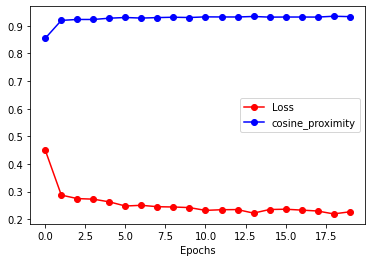

In [202]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["cosine_proximity"], "bo-")
plt.legend(["Loss", "cosine_proximity"])
plt.xlabel("Epochs");

Visualizziamo le probabilità di appartenenza alla classe

In [203]:
keras_model.predict(Xn_val[:5])

array([[0.8175241 , 0.18247588],
       [0.99017966, 0.00982039],
       [0.97425973, 0.02574032],
       [0.09716912, 0.9028309 ],
       [0.99876285, 0.00123713]], dtype=float32)

Visualizziamo la stessa di sopra ma con le classi predette.

In [204]:
keras_model.predict_classes(Xn_val[:5])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 1, 0])

Valutiamo il modello sul validation set

In [205]:
keras_model.evaluate(Xn_val, yt_val)

40/40 [==============================] - 0s 973us/step - loss: 0.1963 - cosine_proximity: 0.9436


[0.1963050216436386, 0.9435897469520569]

Sul modello di rete neurale con Keras abbiamo ottenuto, sul validation set, un'accuratezza del 94% e una loss del 19%.